# BBO-Rietveld LiCoO2

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.


## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)

In [1]:
# import packages
%matplotlib inline

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append('/opt/conda/GSASII/')

In [2]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'LiCoO2'
DATA_DIR = '/bbo_rietveld/data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = '/bbo_rietveld/work/' + STUDY_NAME

In [3]:
# make directories
! rm -f $WORK_DIR/*
! mkdir -p $WORK_DIR

In [4]:
class ProjectLiCoO2:
    def __init__(self, trial_number):
        import GSASIIscriptable as G2sc
        import shutil
        
        # Create a project with a default project name
        shutil.copyfile(DATA_DIR+'/'+'LiCoO2_init.gpx', WORK_DIR+'/'+'LiCoO2_seed{0}_trial_{1}.gpx'.format(RANDOM_SEED, trial_number))
        self.gpx = G2sc.G2Project(gpxfile=os.path.join(WORK_DIR, 'LiCoO2_seed{0}_trial_{1}.gpx'.format(RANDOM_SEED, trial_number)))

        # Add two histograms to the project
        self.hist1 = self.gpx.histograms()[0]
        self.phase0 = self.gpx.phases()[0]
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [16, 80]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 136] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [5]:
def objective(trial):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_uniform('Limits lower bound', 16, 80)
    limits_ub = trial.suggest_uniform('Limits upper bound', limits_lb + 20, 136)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficietns', 1, 15 + 1)  # [1, 16)
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}
    
    refdict_ori = {"set": {"Pref.Ori.": True}}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [16, 136]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict_ori,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    
    def evaluate(trial_number, refine_params_list, q):
        ERROR_PENALTY = 1e9      
        try:
            project = ProjectLiCoO2(trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_LiCoO2 = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_LiCoO2.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            q.put(Rwp)
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            q.put(ERROR_PENALTY)
            
    q = Queue()
    p = Process(target=evaluate, args=(trial.number, refine_params_list, q))
    p.start()
    Rwp = q.get()
    p.join()
    
    return Rwp

In [6]:
# Create Optuna study
study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [7]:
# Optimize
study.optimize(objective, n_trials=200, n_jobs=1)

GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_0.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.215e+06 on 2613 obs.
 Cycle: 0, Time: 0.18s, Chi**2: 95169 for 2613 obs., Lambda: 0.001,  Delta: 0.922
initial chi^2 95169 on 2613 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 95167 for 2613 obs., Lambda: 0.001,  Delta: 2.38e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_0.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_0.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_0.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_0.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 95906 on 2613 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 95268 for 2613 obs., Lambda: 0.001,  Delta: 0.00666
initial chi^

[I 2020-01-12 17:34:25,916] Finished trial#0 resulted in value: 1000000000.0. Current best value is 1000000000.0 with parameters: {'Limits lower bound': 57.452238762366605, 'Limits upper bound': 135.8192970113004, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 2, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_1.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.1101e+05 on 1761 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 66006 for 1761 obs., Lambda: 0.001,  Delta: 0.919
initial chi^2 66006 on 1761 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 66004 for 1761 obs., Lambda: 0.001,  Delta: 2.45e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_1.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_1.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_1.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_1.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 66550 on 1761 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 66547 for 1761 obs., Lambda: 0.001,  Delta: 4.12e-05
converged


[I 2020-01-12 17:34:29,441] Finished trial#1 resulted in value: 23.49499023081628. Current best value is 23.49499023081628 with parameters: {'Limits lower bound': 60.70009609262659, 'Limits upper bound': 113.51243573355376, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficietns': 1, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_2.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0874e+05 on 897 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 27840 for 897 obs., Lambda: 0.001,  Delta: 0.932
initial chi^2 27840 on 897 obs.
 Cycle: 1, Time: 0.05s, Chi**2: 27835 for 897 obs., Lambda: 0.001,  Delta: 0.000181
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_2.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_2.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_2.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_2.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 1.4422e+05 on 897 obs.
 Cycle: 0, Time: 0.04s, Chi**2: 28179 for 897 obs., Lambda: 0.001,  Delta: 0.805
initial chi^2 

[I 2020-01-12 17:34:32,883] Finished trial#2 resulted in value: 24.809242745855954. Current best value is 23.49499023081628 with parameters: {'Limits lower bound': 60.70009609262659, 'Limits upper bound': 113.51243573355376, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficietns': 1, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_3.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.0365e+05 on 917 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 20415 for 917 obs., Lambda: 0.001,  Delta: 0.949
initial chi^2 20415 on 917 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 20414 for 917 obs., Lambda: 0.001,  Delta: 4.69e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_3.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_3.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_3.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_3.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_ri

[I 2020-01-12 17:34:34,324] Finished trial#3 resulted in value: 22.387756506117316. Current best value is 22.387756506117316 with parameters: {'Limits lower bound': 72.9587929595284, 'Limits upper bound': 100.4338844651336, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_4.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.322e+05 on 818 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.2222e+05 for 818 obs., Lambda: 0.001,  Delta: 0.77
initial chi^2 1.2222e+05 on 818 obs.
 Cycle: 1, Time: 0.03s, Chi**2: 1.2222e+05 for 818 obs., Lambda: 0.001,  Delta: 8.83e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_4.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_4.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_4.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_4.gpx
 Hessian Levenberg-Marquardt SVD refinement on 2 variables:
initial chi^2 1.2435e+05 on 818 obs.
 Cycle: 0, Time: 0.03s, Chi**2: 1.2368e+05 for 818 obs., Lambda: 0.001,  Delta: 0.

[I 2020-01-12 17:34:37,082] Finished trial#4 resulted in value: 25.33325419003514. Current best value is 22.387756506117316 with parameters: {'Limits lower bound': 72.9587929595284, 'Limits upper bound': 100.4338844651336, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_5.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.4856e+05 on 783 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 18855 for 783 obs., Lambda: 0.001,  Delta: 0.946
initial chi^2 18855 on 783 obs.
 Cycle: 1, Time: 0.05s, Chi**2: 18853 for 783 obs., Lambda: 0.001,  Delta: 7.46e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_5.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_5.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_5.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_5.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 20005 on 783 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 18543 for 783 obs., Lambda: 0.001,  Delta: 0.0731
initial chi^2 185

[I 2020-01-12 17:34:40,425] Finished trial#5 resulted in value: 22.833791307661706. Current best value is 22.387756506117316 with parameters: {'Limits lower bound': 72.9587929595284, 'Limits upper bound': 100.4338844651336, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficietns': 14, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_6.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.446e+05 on 1059 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 69741 for 1059 obs., Lambda: 0.001,  Delta: 0.872
initial chi^2 69741 on 1059 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 69697 for 1059 obs., Lambda: 0.001,  Delta: 0.000631
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_6.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_6.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_6.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_6.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 69886 on 1059 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 68277 for 1059 obs., Lambda: 0.001,  Delta: 0.023
initial chi^2

[I 2020-01-12 17:34:44,214] Finished trial#6 resulted in value: 12.070192334890336. Current best value is 12.070192334890336 with parameters: {'Limits lower bound': 54.04462149969841, 'Limits upper bound': 85.8067320759842, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_7.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.3185e+05 on 1746 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 78305 for 1746 obs., Lambda: 0.001,  Delta: 0.906
initial chi^2 78305 on 1746 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 78304 for 1746 obs., Lambda: 0.001,  Delta: 2.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_7.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_7.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_7.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_7.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 7.3083e+05 on 1746 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 81965 for 1746 obs., Lambda: 0.001,  Delta: 0.888
initial 

[I 2020-01-12 17:34:48,349] Finished trial#7 resulted in value: 9.445699436110713. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.6372e+05 on 1056 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 22928 for 1056 obs., Lambda: 0.001,  Delta: 0.951
initial chi^2 22928 on 1056 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 22927 for 1056 obs., Lambda: 0.001,  Delta: 4.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 4.0626e+05 on 1056 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 3.7228e+05 for 1056 obs., Lambda: 0.001,  Delta: 0.0836
ini

/opt/conda/GSASII/GSASIImath.py:229: RuntimeWarning: invalid value encountered in true_divide
  Amatlam = Amat/Anorm


ouch #2 linear algebra error in making v-cov matrix
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_8.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.9043e+06 on 4001 obs.
 Cycle: 0, Time: 0.35s, Chi**2: 2.3021e+06 for 4001 obs., Lambda: 0.001,  Delta: 0.741
initial chi^2 2.3022e+06 on 4001 obs.


/opt/conda/GSASII/GSASIIstrMath.py:811: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT)*len(TwinLaw),axis=1).T
/opt/conda/GSASII/GSASIIstrMath.py:2505: RuntimeWarning: invalid value encountered in sqrt
  A = 1.0/np.sqrt((MD*cosP)**2+sinP**2/MD)
/opt/conda/GSASII/GSASIIstrMath.py:36: RuntimeWarning: invalid value encountered in arcsin
  asind = lambda x: 180.*np.arcsin(x)/np.pi
/opt/conda/GSASII/GSASIImath.py:215: UserWarning: Warning: converting a masked element to nan.
  icycle,time.time()-time0,chisq1,Nobs,lamMax,deltaChi2))


 Cycle: 1, Time: 0.58s, Chi**2: nan for 4001 obs., Lambda: 0.001,  Delta: nan


/opt/conda/GSASII/GSASIIstrMath.py:923: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT),axis=1).T
/opt/conda/GSASII/GSASIIstrMath.py:2521: RuntimeWarning: invalid value encountered in sqrt
  A = 1.0/np.sqrt((MD*cosP)**2+sinP**2/MD)
/opt/conda/GSASII/GSASIImpsubs.py:144: RuntimeWarning: invalid value encountered in greater
  refl8im = np.sum(np.where(ratio[iBeg:iFin2]>0.,yp[iBeg:iFin2]*ratio[iBeg:iFin2]/(refl[11+im]*(1.+kRatio)),0.0))
/opt/conda/GSASII/GSASIImath.py:175: RuntimeWarning: invalid value encountered in less
  psing = np.where(np.abs(Adiag) < 1.e-14,True,False)
/opt/conda/GSASII/GSASIImath.py:182: UserWarning: Warning: converting a masked element to nan.
  G2fil.G2Print('initial chi^2 %.5g on %d obs.'%(chisq0,Nobs))


initial chi^2 nan on 4001 obs.
ouch #1 bad SVD inversion; change parameterization for  []


/opt/conda/GSASII/GSASIIstrMain.py:127: UserWarning: Warning: converting a masked element to nan.
  printFile.write(' wR = %7.2f%%, chi**2 = %12.6g, GOF = %6.2f\n'%(Rvals['Rwp'],Rvals['chisq'],Rvals['GOF']))


**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****


[I 2020-01-12 17:34:53,070] Finished trial#8 resulted in value: 45.81304145635423. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_9.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2794e+06 on 2778 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 95630 for 2778 obs., Lambda: 0.001,  Delta: 0.925
initial chi^2 95630 on 2778 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 95627 for 2778 obs., Lambda: 0.001,  Delta: 2.57e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_9.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_9.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_9.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_9.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 96035 on 2778 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 92141 for 2778 obs., Lambda: 0.001,  Delta: 0.0406
initial chi

[I 2020-01-12 17:34:58,424] Finished trial#9 resulted in value: 9.518079398823147. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_10.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 3.8776e+05 on 855 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 21915 for 855 obs., Lambda: 0.001,  Delta: 0.943
initial chi^2 21915 on 855 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 21914 for 855 obs., Lambda: 0.001,  Delta: 4.93e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_10.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_10.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_10.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_10.gpx
 Hessian Levenberg-Marquardt SVD refinement on 5 variables:
initial chi^2 2.9268e+05 on 855 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.7764e+05 for 855 obs., Lambda: 0.001,  Delta: 0.393
init

[I 2020-01-12 17:35:01,935] Finished trial#10 resulted in value: 26.697110136853254. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_11.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 7.5806e+05 on 1739 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 31346 for 1739 obs., Lambda: 0.001,  Delta: 0.959
initial chi^2 31346 on 1739 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 31344 for 1739 obs., Lambda: 0.001,  Delta: 5.87e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_11.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_11.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_11.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_11.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 31371 on 1739 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 31356 for 1739 obs., Lambda: 0.001,  Delta: 0.00048
conver

[I 2020-01-12 17:35:05,799] Finished trial#11 resulted in value: 11.054266471326548. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_12.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.5532e+05 on 1813 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 78786 for 1813 obs., Lambda: 0.001,  Delta: 0.908
initial chi^2 78786 on 1813 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 78784 for 1813 obs., Lambda: 0.001,  Delta: 2.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_12.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_12.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_12.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_12.gpx
 Hessian Levenberg-Marquardt SVD refinement on 5 variables:
initial chi^2 6.9084e+05 on 1813 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.0862e+05 for 1813 obs., Lambda: 0.001,  Delta: 0.84

[I 2020-01-12 17:35:09,637] Finished trial#12 resulted in value: 18.16959680852385. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_13.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1427e+06 on 2029 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9617e+05 for 2029 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9617e+05 on 2029 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9616e+05 for 2029 obs., Lambda: 0.001,  Delta: 9.94e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_13.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_13.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_13.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_13.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 1.9781e+05 on 2029 obs.
new chi^2 1.9867e+05 on 2029 obs., 0 SVD zeros ; matrix modification 

[I 2020-01-12 17:35:14,129] Finished trial#13 resulted in value: 28.03036906747319. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_14.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.084e+06 on 2305 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 90625 for 2305 obs., Lambda: 0.001,  Delta: 0.916
initial chi^2 90625 on 2305 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 90623 for 2305 obs., Lambda: 0.001,  Delta: 2.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_14.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_14.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_14.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_14.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 91224 on 2305 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 91209 for 2305 obs., Lambda: 0.001,  Delta: 0.000163
conver

[I 2020-01-12 17:35:18,070] Finished trial#14 resulted in value: 24.812121618090387. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_15.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.163e+06 on 2072 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9623e+05 for 2072 obs., Lambda: 0.001,  Delta: 0.831
initial chi^2 1.9623e+05 on 2072 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9623e+05 for 2072 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_15.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_15.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_15.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_15.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.9623e+05 on 2072 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9623e+05 for 2072 obs., Lambda: 0.001

[I 2020-01-12 17:35:22,350] Finished trial#15 resulted in value: 24.27334057935506. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 7.4869e+05 on 1674 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 34265 for 1674 obs., Lambda: 0.001,  Delta: 0.954
initial chi^2 34265 on 1674 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 34263 for 1674 obs., Lambda: 0.001,  Delta: 4.94e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 4.3248e+05 on 1674 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 3.9808e+05 for 1674 obs., Lambda: 0.001,  Delta: 0.07

/opt/conda/GSASII/GSASIIstrMath.py:811: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT)*len(TwinLaw),axis=1).T


new chi^2 1.2569e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 1.1394e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-01
 Cycle: 0, Time: 0.48s, Chi**2: 9.6417e+05 for 4001 obs., Lambda: 0.01,  Delta: 0.121


/opt/conda/GSASII/GSASIIstrMath.py:923: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT),axis=1).T


initial chi^2 9.6416e+05 on 4001 obs.
 Cycle: 1, Time: 0.34s, Chi**2: 7.9541e+05 for 4001 obs., Lambda: 0.01,  Delta: 0.175
initial chi^2 7.9545e+05 on 4001 obs.
new chi^2 7.9838e+05 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 7.9867e+05 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-01
 Cycle: 2, Time: 0.48s, Chi**2: 7.6333e+05 for 4001 obs., Lambda: 0.01,  Delta: 0.0404
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_16.lst
 ***** Refinement successful *****


[I 2020-01-12 17:35:27,727] Finished trial#16 resulted in value: 1000000000.0. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_17.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.1578e+05 on 815 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 50307 for 815 obs., Lambda: 0.001,  Delta: 0.879
initial chi^2 50307 on 815 obs.
 Cycle: 1, Time: 0.04s, Chi**2: 50305 for 815 obs., Lambda: 0.001,  Delta: 3.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_17.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_17.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_17.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_17.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 3.4861e+05 on 815 obs.
 Cycle: 0, Time: 0.04s, Chi**2: 3.3596e+05 for 815 obs., Lambda: 0.001,  Delta: 0.0363
ini

[I 2020-01-12 17:35:31,014] Finished trial#17 resulted in value: 1000000000.0. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_18.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1238e+06 on 2389 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 92596 for 2389 obs., Lambda: 0.001,  Delta: 0.918
initial chi^2 92596 on 2389 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 92594 for 2389 obs., Lambda: 0.001,  Delta: 2.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_18.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_18.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_18.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_18.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 95703 on 2389 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 90965 for 2389 obs., Lambda: 0.001,  Delta: 0.0495
initial

[I 2020-01-12 17:35:36,516] Finished trial#18 resulted in value: 9.542823947367797. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_19.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2036e+06 on 2594 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 93239 for 2594 obs., Lambda: 0.001,  Delta: 0.923
initial chi^2 93239 on 2594 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 93236 for 2594 obs., Lambda: 0.001,  Delta: 2.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_19.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_19.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_19.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_19.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 2.8325e+08 on 2594 obs.
new chi^2 4.5319e+21 on 2594 obs., 0 SVD zeros ; matrix modification needed; lambda 

[I 2020-01-12 17:35:41,052] Finished trial#19 resulted in value: 100.0. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_20.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.7986e+05 on 945 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.2634e+05 for 945 obs., Lambda: 0.001,  Delta: 0.782
initial chi^2 1.2634e+05 on 945 obs.
 Cycle: 1, Time: 0.04s, Chi**2: 1.2634e+05 for 945 obs., Lambda: 0.001,  Delta: 8.27e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_20.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_20.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_20.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_20.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.2688e+05 on 945 obs.
new chi^2 1.344e+05 on 945 obs., 0 SVD zeros ; matrix modification needed;

[I 2020-01-12 17:35:44,783] Finished trial#20 resulted in value: 100.0. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_21.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.672e+05 on 1122 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 70083 for 1122 obs., Lambda: 0.001,  Delta: 0.876
initial chi^2 70083 on 1122 obs.
 Cycle: 1, Time: 0.05s, Chi**2: 70082 for 1122 obs., Lambda: 0.001,  Delta: 1.7e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_21.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_21.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_21.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_21.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 70408 on 1122 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 69080 for 1122 obs., Lambda: 0.001,  Delta: 0.0189
initial 

[I 2020-01-12 17:35:48,666] Finished trial#21 resulted in value: 10.134255871025562. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_22.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2417e+06 on 2449 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.6286e+05 for 2449 obs., Lambda: 0.001,  Delta: 0.869
initial chi^2 1.6286e+05 on 2449 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.6286e+05 for 2449 obs., Lambda: 0.001,  Delta: 1.61e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_22.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_22.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_22.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_22.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.684e+05 on 2449 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.6132e+05 for 2449 obs., Lambda: 0.00

[I 2020-01-12 17:35:54,270] Finished trial#22 resulted in value: 10.240055909652748. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_23.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.5402e+06 on 3121 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 1.7657e+05 for 3121 obs., Lambda: 0.001,  Delta: 0.885
initial chi^2 1.7657e+05 on 3121 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 1.7656e+05 for 3121 obs., Lambda: 0.001,  Delta: 3.49e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_23.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_23.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_23.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_23.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.8007e+05 on 3121 obs.
 Cycle: 0, Time: 0.15s, Chi**2: 1.7526e+05 for 3121 obs., Lambda: 0.0

[I 2020-01-12 17:36:00,049] Finished trial#23 resulted in value: 10.379288671498072. Current best value is 9.445699436110713 with parameters: {'Limits lower bound': 50.729110045542264, 'Limits upper bound': 103.0837299139051, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_24.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.6464e+06 on 3168 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 2.1196e+05 for 3168 obs., Lambda: 0.001,  Delta: 0.871
initial chi^2 2.1196e+05 on 3168 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 2.1196e+05 for 3168 obs., Lambda: 0.001,  Delta: 4e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_24.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_24.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_24.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_24.gpx
 Hessian Levenberg-Marquardt SVD refinement on 17 variables:
initial chi^2 2.352e+05 on 3168 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 2.0866e+05 for 3168 obs., Lambda: 0.001, 

[I 2020-01-12 17:36:05,483] Finished trial#24 resulted in value: 9.260754960750623. Current best value is 9.260754960750623 with parameters: {'Limits lower bound': 24.782830037205038, 'Limits upper bound': 119.79096124505313, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_25.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.62e+06 on 3126 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 2.0982e+05 for 3126 obs., Lambda: 0.001,  Delta: 0.87
initial chi^2 2.0982e+05 on 3126 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 2.0982e+05 for 3126 obs., Lambda: 0.001,  Delta: 1.33e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_25.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_25.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_25.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_25.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.4068e+06 on 3126 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.1372e+05 for 3126 obs., Lambda: 0.001,

[I 2020-01-12 17:36:10,415] Finished trial#25 resulted in value: 9.267688707037744. Current best value is 9.260754960750623 with parameters: {'Limits lower bound': 24.782830037205038, 'Limits upper bound': 119.79096124505313, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficietns': 16, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_26.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.0333e+06 on 3404 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 3.9406e+05 for 3404 obs., Lambda: 0.001,  Delta: 0.806
initial chi^2 3.9406e+05 on 3404 obs.
 Cycle: 1, Time: 0.14s, Chi**2: 3.9406e+05 for 3404 obs., Lambda: 0.001,  Delta: 9.71e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_26.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_26.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_26.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_26.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.7271e+06 on 3404 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 3.9251e+05 for 3404 obs., Lambda: 0.0

[I 2020-01-12 17:36:15,719] Finished trial#26 resulted in value: 9.095851493646707. Current best value is 9.095851493646707 with parameters: {'Limits lower bound': 16.085264109234696, 'Limits upper bound': 118.17818685093796, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_27.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 7.046e+05 on 781 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.1728e+05 for 781 obs., Lambda: 0.001,  Delta: 0.692
initial chi^2 2.1728e+05 on 781 obs.
 Cycle: 1, Time: 0.03s, Chi**2: 2.1728e+05 for 781 obs., Lambda: 0.001,  Delta: 4.32e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_27.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_27.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_27.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_27.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 5.8308e+05 on 781 obs.
 Cycle: 0, Time: 0.04s, Chi**2: 2.0041e+05 for 781 obs., Lambda: 0.001,  De

[I 2020-01-12 17:36:19,076] Finished trial#27 resulted in value: 12.17668762034326. Current best value is 9.095851493646707 with parameters: {'Limits lower bound': 16.085264109234696, 'Limits upper bound': 118.17818685093796, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_28.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 2.0305e+06 on 3400 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 3.9399e+05 for 3400 obs., Lambda: 0.001,  Delta: 0.806
initial chi^2 3.9399e+05 on 3400 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 3.9398e+05 for 3400 obs., Lambda: 0.001,  Delta: 1.55e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_28.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_28.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_28.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_28.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 1.7253e+06 on 3400 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 3.9191e+05 for 3400 obs., Lambda: 0.0

[I 2020-01-12 17:36:24,120] Finished trial#28 resulted in value: 8.92753713861655. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_29.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.8972e+06 on 3118 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 3.884e+05 for 3118 obs., Lambda: 0.001,  Delta: 0.795
initial chi^2 3.884e+05 on 3118 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 3.884e+05 for 3118 obs., Lambda: 0.001,  Delta: 6.77e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_29.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_29.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_29.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_29.gpx
 Hessian Levenberg-Marquardt SVD refinement on 7 variables:
initial chi^2 1.4976e+06 on 3118 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 4.0417e+05 for 3118 obs., Lambda: 0.001, 

[I 2020-01-12 17:36:28,375] Finished trial#29 resulted in value: 8.998693369171066. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_30.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.9074e+06 on 3160 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 3.8869e+05 for 3160 obs., Lambda: 0.001,  Delta: 0.796
initial chi^2 3.8869e+05 on 3160 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 3.8868e+05 for 3160 obs., Lambda: 0.001,  Delta: 1.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_30.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_30.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_30.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_30.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.5351e+06 on 3160 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 4.0005e+05 for 3160 obs., Lambda: 0.001

[I 2020-01-12 17:36:33,403] Finished trial#30 resulted in value: 8.985853746022368. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_31.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.8588e+06 on 3082 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 3.8287e+05 for 3082 obs., Lambda: 0.001,  Delta: 0.794
initial chi^2 3.8287e+05 on 3082 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 3.8286e+05 for 3082 obs., Lambda: 0.001,  Delta: 1.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_31.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_31.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_31.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_31.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.4992e+06 on 3082 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 3.9437e+05 for 3082 obs., Lambda: 0.00

[I 2020-01-12 17:36:38,382] Finished trial#31 resulted in value: 9.029883445888753. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_32.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.555e+06 on 2964 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.0305e+05 for 2964 obs., Lambda: 0.001,  Delta: 0.869
initial chi^2 2.0305e+05 on 2964 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 2.0305e+05 for 2964 obs., Lambda: 0.001,  Delta: 1.34e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_32.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_32.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_32.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_32.gpx
 Hessian Levenberg-Marquardt SVD refinement on 7 variables:
initial chi^2 1.2672e+06 on 2964 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.2104e+05 for 2964 obs., Lambda: 0.001

[I 2020-01-12 17:36:42,540] Finished trial#32 resulted in value: 9.05937394094639. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_33.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.5734e+06 on 3022 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.034e+05 for 3022 obs., Lambda: 0.001,  Delta: 0.871
initial chi^2 2.034e+05 on 3022 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 2.034e+05 for 3022 obs., Lambda: 0.001,  Delta: 1.8e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_33.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_33.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_33.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_33.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.3061e+06 on 3022 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 2.1822e+05 for 3022 obs., Lambda: 0.001,  

[I 2020-01-12 17:36:47,305] Finished trial#33 resulted in value: 9.36481417685525. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_34.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.9005e+06 on 3118 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 3.8845e+05 for 3118 obs., Lambda: 0.001,  Delta: 0.796
initial chi^2 3.8845e+05 on 3118 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 3.8845e+05 for 3118 obs., Lambda: 0.001,  Delta: 6.69e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_34.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_34.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_34.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_34.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.5333e+06 on 3118 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 3.9426e+05 for 3118 obs., Lambda: 0.00

[I 2020-01-12 17:36:51,912] Finished trial#34 resulted in value: 8.932604973278918. Current best value is 8.92753713861655 with parameters: {'Limits lower bound': 16.127010003810735, 'Limits upper bound': 118.09605662159565, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficietns': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_35.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2957e+06 on 2373 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9888e+05 for 2373 obs., Lambda: 0.001,  Delta: 0.847
initial chi^2 1.9888e+05 on 2373 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9888e+05 for 2373 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_35.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_35.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_35.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_35.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.0786e+06 on 2373 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.1638e+05 for 2373 obs., Lambda: 0.00

[I 2020-01-12 17:36:56,416] Finished trial#35 resulted in value: 8.835149046206112. Current best value is 8.835149046206112 with parameters: {'Limits lower bound': 26.759814800461665, 'Limits upper bound': 97.92919451749025, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_36.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.287e+06 on 2359 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9891e+05 for 2359 obs., Lambda: 0.001,  Delta: 0.845
initial chi^2 1.9891e+05 on 2359 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9891e+05 for 2359 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_36.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_36.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_36.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_36.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.0731e+06 on 2359 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.1447e+05 for 2359 obs., Lambda: 0.001

[I 2020-01-12 17:37:00,840] Finished trial#36 resulted in value: 8.834640162791096. Current best value is 8.834640162791096 with parameters: {'Limits lower bound': 27.834821990424228, 'Limits upper bound': 98.58727855020966, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_37.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0264e+06 on 1774 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.8358e+05 for 1774 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.8358e+05 on 1774 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.8358e+05 for 1774 obs., Lambda: 0.001,  Delta: 9.71e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_37.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_37.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_37.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_37.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.4473e+05 on 1774 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.9279e+05 for 1774 obs., Lambda: 0.00

[I 2020-01-12 17:37:05,232] Finished trial#37 resulted in value: 10.32474722834451. Current best value is 8.834640162791096 with parameters: {'Limits lower bound': 27.834821990424228, 'Limits upper bound': 98.58727855020966, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_38.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1903e+06 on 2147 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9844e+05 for 2147 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 1.9844e+05 on 2147 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9844e+05 for 2147 obs., Lambda: 0.001,  Delta: 1.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_38.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_38.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_38.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_38.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gp

[I 2020-01-12 17:37:07,084] Finished trial#38 resulted in value: 40.54918602966929. Current best value is 8.834640162791096 with parameters: {'Limits lower bound': 27.834821990424228, 'Limits upper bound': 98.58727855020966, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_39.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.3592e+06 on 2509 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9929e+05 for 2509 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 1.9929e+05 on 2509 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9928e+05 for 2509 obs., Lambda: 0.001,  Delta: 1.2e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_39.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_39.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_39.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_39.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.1562e+06 on 2509 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0692e+05 for 2509 obs., Lambda: 0.00

[I 2020-01-12 17:37:11,551] Finished trial#39 resulted in value: 8.832986770667185. Current best value is 8.832986770667185 with parameters: {'Limits lower bound': 23.640900181254334, 'Limits upper bound': 98.86940883986598, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_40.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.3344e+06 on 2458 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.991e+05 for 2458 obs., Lambda: 0.001,  Delta: 0.851
initial chi^2 1.991e+05 on 2458 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.991e+05 for 2458 obs., Lambda: 0.001,  Delta: 1.18e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_40.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_40.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_40.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_40.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.1341e+06 on 2458 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0675e+05 for 2458 obs., Lambda: 0.001,

[I 2020-01-12 17:37:16,251] Finished trial#40 resulted in value: 8.83498664910679. Current best value is 8.832986770667185 with parameters: {'Limits lower bound': 23.640900181254334, 'Limits upper bound': 98.86940883986598, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_41.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1618e+06 on 2040 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9211e+05 for 2040 obs., Lambda: 0.001,  Delta: 0.835
initial chi^2 1.9211e+05 on 2040 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9211e+05 for 2040 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_41.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_41.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_41.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_41.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.7066e+05 on 2040 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9354e+05 for 2040 obs., Lambda: 0.0

[I 2020-01-12 17:37:20,281] Finished trial#41 resulted in value: 8.807593657520748. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_42.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1575e+06 on 2033 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9213e+05 for 2033 obs., Lambda: 0.001,  Delta: 0.834
initial chi^2 1.9213e+05 on 2033 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9213e+05 for 2033 obs., Lambda: 0.001,  Delta: 1.03e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_42.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_42.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_42.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_42.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.6749e+05 on 2033 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9288e+05 for 2033 obs., Lambda: 0.0

[I 2020-01-12 17:37:24,562] Finished trial#42 resulted in value: 8.809815911733782. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_43.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.015e+06 on 1728 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.7825e+05 for 1728 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.7825e+05 on 1728 obs.
 Cycle: 1, Time: 0.05s, Chi**2: 1.7825e+05 for 1728 obs., Lambda: 0.001,  Delta: 9.59e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_43.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_43.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_43.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_43.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.5609e+05 on 1728 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.8333e+05 for 1728 obs., Lambda: 0.00

[I 2020-01-12 17:37:29,070] Finished trial#43 resulted in value: 10.179138880609342. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_44.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1031e+06 on 1909 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9491e+05 for 1909 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.9491e+05 on 1909 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9491e+05 for 1909 obs., Lambda: 0.001,  Delta: 9.75e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_44.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_44.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_44.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_44.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.1085e+05 on 1909 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.082e+05 for 1909 obs., Lambda: 0.00

[I 2020-01-12 17:37:33,213] Finished trial#44 resulted in value: 9.28994797688452. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_45.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.053e+06 on 1801 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9494e+05 for 1801 obs., Lambda: 0.001,  Delta: 0.815
initial chi^2 1.9494e+05 on 1801 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9494e+05 for 1801 obs., Lambda: 0.001,  Delta: 8.89e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_45.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_45.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_45.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_45.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.9494e+05 on 1801 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9365e+05 for 1801 obs., Lambda: 0.00

[I 2020-01-12 17:37:37,848] Finished trial#45 resulted in value: 9.311164685354054. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_46.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1042e+06 on 1923 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.8382e+05 for 1923 obs., Lambda: 0.001,  Delta: 0.834
initial chi^2 1.8382e+05 on 1923 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.8381e+05 for 1923 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_46.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_46.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_46.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_46.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.4962e+05 on 1923 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.9964e+05 for 1923 obs., Lambda: 0.0

[I 2020-01-12 17:37:42,375] Finished trial#46 resulted in value: 10.320362299588474. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_47.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1905e+06 on 2139 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9853e+05 for 2139 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 1.9853e+05 on 2139 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9852e+05 for 2139 obs., Lambda: 0.001,  Delta: 1.03e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_47.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_47.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_47.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_47.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 2.0044e+05 on 2139 obs.
new chi^2 2.0147e+05 on 2139 obs., 0 SVD zeros ; matrix modification 

[I 2020-01-12 17:37:46,902] Finished trial#47 resulted in value: 19.52290455465935. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_48.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.4887e+05 on 1367 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.7722e+05 for 1367 obs., Lambda: 0.001,  Delta: 0.791
initial chi^2 1.7722e+05 on 1367 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 1.7722e+05 for 1367 obs., Lambda: 0.001,  Delta: 8.22e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_48.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_48.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_48.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_48.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 2.3875e+07 on 1367 obs.
new chi^2 2.5626e+15 on 1367 obs., 0 SVD zeros ; matrix modification 

[I 2020-01-12 17:37:49,965] Finished trial#48 resulted in value: 100.0. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_49.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.4253e+06 on 2678 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.0174e+05 for 2678 obs., Lambda: 0.001,  Delta: 0.858
initial chi^2 2.0174e+05 on 2678 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.0174e+05 for 2678 obs., Lambda: 0.001,  Delta: 1.26e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_49.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_49.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_49.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_49.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.3112e+06 on 2678 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.2919e+06 for 2678 obs., Lambda: 0.00

[I 2020-01-12 17:37:55,878] Finished trial#49 resulted in value: 1000000000.0. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_50.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.0326e+05 on 1340 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.3735e+05 for 1340 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 1.3735e+05 on 1340 obs.
 Cycle: 1, Time: 0.04s, Chi**2: 1.3735e+05 for 1340 obs., Lambda: 0.001,  Delta: 1.17e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_50.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_50.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_50.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_50.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 6.6981e+05 on 1340 obs.
 Cycle: 0, Time: 0.05s, Chi**2: 1.449e+05 for 1340 obs., Lambda: 0.001

[I 2020-01-12 17:37:59,497] Finished trial#50 resulted in value: 23.606411446988062. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_51.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.278e+06 on 2327 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9877e+05 for 2327 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 1.9877e+05 on 2327 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9876e+05 for 2327 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_51.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_51.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_51.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_51.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.0596e+06 on 2327 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.1392e+05 for 2327 obs., Lambda: 0.001

[I 2020-01-12 17:38:04,114] Finished trial#51 resulted in value: 8.834021939626027. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_52.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2566e+06 on 2257 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9644e+05 for 2257 obs., Lambda: 0.001,  Delta: 0.844
initial chi^2 1.9644e+05 on 2257 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9643e+05 for 2257 obs., Lambda: 0.001,  Delta: 1.08e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_52.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_52.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_52.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_52.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.0498e+06 on 2257 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0174e+05 for 2257 obs., Lambda: 0.0

[I 2020-01-12 17:38:08,639] Finished trial#52 resulted in value: 9.29413681535549. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_53.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1026e+06 on 1918 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.919e+05 for 1918 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.919e+05 on 1918 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.919e+05 for 1918 obs., Lambda: 0.001,  Delta: 9.99e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_53.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_53.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_53.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_53.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 9.2402e+05 on 1918 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.9551e+05 for 1918 obs., Lambda: 0.001,

[I 2020-01-12 17:38:12,664] Finished trial#53 resulted in value: 8.985791112300634. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_54.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2158e+06 on 2186 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9854e+05 for 2186 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 1.9854e+05 on 2186 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9854e+05 for 2186 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_54.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_54.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_54.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_54.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.0201e+06 on 2186 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0805e+05 for 2186 obs., Lambda: 0.0

[I 2020-01-12 17:38:17,339] Finished trial#54 resulted in value: 8.869310069450464. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_55.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2088e+06 on 2182 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 2.0041e+05 for 2182 obs., Lambda: 0.001,  Delta: 0.834
initial chi^2 2.0041e+05 on 2182 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.0041e+05 for 2182 obs., Lambda: 0.001,  Delta: 1.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_55.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_55.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_55.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_55.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.8976e+05 on 2182 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 2.0683e+05 for 2182 obs., Lambda: 0.001

[I 2020-01-12 17:38:21,922] Finished trial#55 resulted in value: 9.348551753157421. Current best value is 8.807593657520748 with parameters: {'Limits lower bound': 23.94324324554709, 'Limits upper bound': 85.1057515404043, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_56.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0523e+06 on 1795 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9459e+05 for 1795 obs., Lambda: 0.001,  Delta: 0.815
initial chi^2 1.9459e+05 on 1795 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9459e+05 for 1795 obs., Lambda: 0.001,  Delta: 8.97e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_56.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_56.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_56.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_56.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.5567e+05 on 1795 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0524e+05 for 1795 obs., Lambda: 0.0

[I 2020-01-12 17:38:26,675] Finished trial#56 resulted in value: 8.446580187116561. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_57.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.89e+05 on 1687 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.856e+05 for 1687 obs., Lambda: 0.001,  Delta: 0.812
initial chi^2 1.856e+05 on 1687 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.856e+05 for 1687 obs., Lambda: 0.001,  Delta: 8.69e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_57.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_57.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_57.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_57.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.856e+05 on 1687 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.856e+05 for 1687 obs., Lambda: 0.001,  Del

[I 2020-01-12 17:38:30,699] Finished trial#57 resulted in value: 15.725323691026642. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_58.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.6542e+05 on 1699 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.6736e+05 for 1699 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.6736e+05 on 1699 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.6736e+05 for 1699 obs., Lambda: 0.001,  Delta: 9.49e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_58.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_58.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_58.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_58.gpx
 Hessian Levenberg-Marquardt SVD refinement on 7 variables:
initial chi^2 7.6958e+05 on 1699 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.8453e+05 for 1699 obs., Lambda: 0.00

[I 2020-01-12 17:38:34,856] Finished trial#58 resulted in value: 9.25926395752876. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_59.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0961e+06 on 1900 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.791e+05 for 1900 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 1.791e+05 on 1900 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 1.791e+05 for 1900 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_59.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_59.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_59.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_59.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 9.3769e+05 on 1900 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.8429e+05 for 1900 obs., Lambda: 0.001,

[I 2020-01-12 17:38:38,781] Finished trial#59 resulted in value: 24.20533216415309. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_60.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1537e+06 on 2052 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.962e+05 for 2052 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.962e+05 on 2052 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.962e+05 for 2052 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_60.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_60.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_60.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_60.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.9776e+05 on 2052 obs.
new chi^2 1.987e+05 on 2052 obs., 0 SVD zeros ; matrix modification neede

[I 2020-01-12 17:38:43,423] Finished trial#60 resulted in value: 11.292702221623. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_61.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.3048e+06 on 2388 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.989e+05 for 2388 obs., Lambda: 0.001,  Delta: 0.848
initial chi^2 1.989e+05 on 2388 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.989e+05 for 2388 obs., Lambda: 0.001,  Delta: 1.16e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_61.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_61.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_61.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_61.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.1052e+06 on 2388 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0868e+05 for 2388 obs., Lambda: 0.001,

[I 2020-01-12 17:38:47,861] Finished trial#61 resulted in value: 8.75514998521322. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_62.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2559e+06 on 2281 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9739e+05 for 2281 obs., Lambda: 0.001,  Delta: 0.843
initial chi^2 1.9739e+05 on 2281 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9739e+05 for 2281 obs., Lambda: 0.001,  Delta: 1.23e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_62.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_62.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_62.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_62.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.0446e+06 on 2281 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0405e+05 for 2281 obs., Lambda: 0.00

[I 2020-01-12 17:38:52,643] Finished trial#62 resulted in value: 8.483987891336888. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_63.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1486e+06 on 2007 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9503e+05 for 2007 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.9503e+05 on 2007 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9503e+05 for 2007 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_63.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_63.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_63.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_63.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 9.6055e+05 on 2007 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0727e+05 for 2007 obs., Lambda: 0.00

[I 2020-01-12 17:38:56,914] Finished trial#63 resulted in value: 8.58256876497595. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_64.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2044e+06 on 2121 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9546e+05 for 2121 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 1.9546e+05 on 2121 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9546e+05 for 2121 obs., Lambda: 0.001,  Delta: 1.87e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_64.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_64.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_64.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_64.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0154e+06 on 2121 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.0216e+05 for 2121 obs., Lambda: 0.0

[I 2020-01-12 17:39:01,242] Finished trial#64 resulted in value: 8.465704136743442. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_65.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.161e+06 on 2034 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9508e+05 for 2034 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 1.9508e+05 on 2034 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9508e+05 for 2034 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_65.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_65.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_65.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_65.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.5072e+08 on 2034 obs.
new chi^2 1.4815e+20 on 2034 obs., 0 SVD zeros ; matrix modification n

[I 2020-01-12 17:39:05,198] Finished trial#65 resulted in value: 100.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_66.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1482e+06 on 2022 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.8421e+05 for 2022 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 1.8421e+05 on 2022 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.842e+05 for 2022 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_66.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_66.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_66.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_66.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 9.8042e+05 on 2022 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.8743e+05 for 2022 obs., Lambda: 0.001

[I 2020-01-12 17:39:10,367] Finished trial#66 resulted in value: 9.718154500337853. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_67.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.2957e+05 on 1571 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.778e+05 for 1571 obs., Lambda: 0.001,  Delta: 0.809
initial chi^2 1.778e+05 on 1571 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 1.7779e+05 for 1571 obs., Lambda: 0.001,  Delta: 9.14e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_67.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_67.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_67.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_67.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 7.8823e+05 on 1571 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.7945e+05 for 1571 obs., Lambda: 0.001

[I 2020-01-12 17:39:14,141] Finished trial#67 resulted in value: 14.329282222364151. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_68.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.137e+06 on 2008 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9607e+05 for 2008 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9607e+05 on 2008 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9607e+05 for 2008 obs., Lambda: 0.001,  Delta: 9.77e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_68.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_68.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_68.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_68.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 9.6222e+05 on 2008 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9886e+05 for 2008 obs., Lambda: 0.00

[I 2020-01-12 17:39:18,843] Finished trial#68 resulted in value: 8.625005965981808. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.0316e+05 on 1627 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.5416e+05 for 1627 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 1.5416e+05 on 1627 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.5416e+05 for 1627 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 7.6994e+05 on 1627 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 7.5798e+05 for 1627 obs., Lambda: 0.00

/opt/conda/GSASII/GSASIIstrMath.py:811: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT)*len(TwinLaw),axis=1).T


 Cycle: 0, Time: 0.34s, Chi**2: 1.6966e+06 for 4001 obs., Lambda: 0.001,  Delta: 0.739


/opt/conda/GSASII/GSASIIstrMath.py:923: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT),axis=1).T


initial chi^2 1.6966e+06 on 4001 obs.
new chi^2 4.8198e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-03
new chi^2 1.0075e+07 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 5.6384e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-01
new chi^2 2.0527e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+00
new chi^2 1.8208e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+01
new chi^2 1.7746e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+02
ouch #3 chisq1 1.7746e+06.4 stuck > chisq0 1.69659e+06.4
 Cycle: 1, Time: 0.93s, Chi**2: 1.7746e+06 for 4001 obs., Lambda: 100,  Delta: -0.046
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_69.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietvel

[I 2020-01-12 17:39:23,851] Finished trial#69 resulted in value: 1000000000.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_70.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.9887e+05 on 1839 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.6342e+05 for 1839 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 1.6342e+05 on 1839 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.6341e+05 for 1839 obs., Lambda: 0.001,  Delta: 1.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_70.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_70.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_70.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_70.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gp

[I 2020-01-12 17:39:25,702] Finished trial#70 resulted in value: 40.188336905250225. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_71.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0761e+06 on 1850 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9479e+05 for 1850 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.9479e+05 on 1850 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9478e+05 for 1850 obs., Lambda: 0.001,  Delta: 9e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_71.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_71.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_71.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_71.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 8.9167e+05 on 1850 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.002e+05 for 1850 obs., Lambda: 0.001, 

[I 2020-01-12 17:39:30,527] Finished trial#71 resulted in value: 8.506447751917872. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_72.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0515e+06 on 1791 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9475e+05 for 1791 obs., Lambda: 0.001,  Delta: 0.815
initial chi^2 1.9475e+05 on 1791 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9475e+05 for 1791 obs., Lambda: 0.001,  Delta: 8.75e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_72.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_72.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_72.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_72.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 8.7965e+05 on 1791 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9245e+05 for 1791 obs., Lambda: 0.0

[I 2020-01-12 17:39:35,273] Finished trial#72 resulted in value: 9.255272094962372. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_73.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1422e+06 on 2016 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9601e+05 for 2016 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9601e+05 on 2016 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9601e+05 for 2016 obs., Lambda: 0.001,  Delta: 9.8e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_73.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_73.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_73.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_73.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.7043e+05 on 2016 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9884e+05 for 2016 obs., Lambda: 0.00

[I 2020-01-12 17:39:40,164] Finished trial#73 resulted in value: 8.462684776572281. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_74.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.145e+06 on 2024 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9605e+05 for 2024 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 1.9605e+05 on 2024 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9605e+05 for 2024 obs., Lambda: 0.001,  Delta: 9.86e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_74.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_74.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_74.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_74.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.7356e+05 on 2024 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9877e+05 for 2024 obs., Lambda: 0.00

[I 2020-01-12 17:39:44,905] Finished trial#74 resulted in value: 8.49237425296357. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_75.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1538e+06 on 2044 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9607e+05 for 2044 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.9607e+05 on 2044 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9607e+05 for 2044 obs., Lambda: 0.001,  Delta: 9.96e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_75.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_75.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_75.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_75.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.8193e+05 on 2044 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9914e+05 for 2044 obs., Lambda: 0.00

[I 2020-01-12 17:39:49,507] Finished trial#75 resulted in value: 9.145604751484607. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_76.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0657e+06 on 1831 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.952e+05 for 1831 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.952e+05 on 1831 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.952e+05 for 1831 obs., Lambda: 0.001,  Delta: 8.75e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_76.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_76.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_76.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_76.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 8.971e+05 on 1831 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9444e+05 for 1831 obs., Lambda: 0.001, 

[I 2020-01-12 17:39:53,839] Finished trial#76 resulted in value: 9.269275560132199. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_77.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.1324e+05 on 1545 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.7777e+05 for 1545 obs., Lambda: 0.001,  Delta: 0.805
initial chi^2 1.7777e+05 on 1545 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 1.7776e+05 for 1545 obs., Lambda: 0.001,  Delta: 8.94e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_77.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_77.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_77.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_77.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 7.7998e+05 on 1545 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.7814e+05 for 1545 obs., Lambda: 0.0

[I 2020-01-12 17:39:58,200] Finished trial#77 resulted in value: 9.858774418921143. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_78.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 8.3632e+05 on 1466 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.5164e+05 for 1466 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.5164e+05 on 1466 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.5163e+05 for 1466 obs., Lambda: 0.001,  Delta: 2.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_78.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_78.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_78.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_78.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 7.0207e+05 on 1466 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.5107e+05 for 1466 obs., Lambda: 0.0

[I 2020-01-12 17:40:02,386] Finished trial#78 resulted in value: 25.051056689498846. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_79.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0939e+06 on 1919 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9569e+05 for 1919 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.9569e+05 on 1919 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9568e+05 for 1919 obs., Lambda: 0.001,  Delta: 1.87e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_79.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_79.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_79.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_79.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.9568e+05 on 1919 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9172e+05 for 1919 obs., Lambda: 0.0

[I 2020-01-12 17:40:07,268] Finished trial#79 resulted in value: 9.256597943600687. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_80.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 7.4209e+05 on 1496 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 83398 for 1496 obs., Lambda: 0.001,  Delta: 0.888
initial chi^2 83398 on 1496 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 83397 for 1496 obs., Lambda: 0.001,  Delta: 1.82e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_80.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_80.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_80.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_80.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 6.4154e+05 on 1496 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 87914 for 1496 obs., Lambda: 0.001,  Delta: 0.863
in

[I 2020-01-12 17:40:11,409] Finished trial#80 resulted in value: 9.243132187259535. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_81.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1497e+06 on 2021 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9571e+05 for 2021 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.9571e+05 on 2021 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9571e+05 for 2021 obs., Lambda: 0.001,  Delta: 9.75e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_81.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_81.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_81.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_81.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.7407e+05 on 2021 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.9757e+05 for 2021 obs., Lambda: 0.00

[I 2020-01-12 17:40:16,186] Finished trial#81 resulted in value: 8.511269592738627. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_82.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1317e+06 on 1975 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9545e+05 for 1975 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9545e+05 on 1975 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9545e+05 for 1975 obs., Lambda: 0.001,  Delta: 9.6e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_82.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_82.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_82.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_82.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 9.5884e+05 on 1975 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9389e+05 for 1975 obs., Lambda: 0.00

[I 2020-01-12 17:40:20,926] Finished trial#82 resulted in value: 9.257106084351275. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_83.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.103e+06 on 1921 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9565e+05 for 1921 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.9565e+05 on 1921 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9565e+05 for 1921 obs., Lambda: 0.001,  Delta: 9.17e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_83.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_83.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_83.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_83.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.3027e+05 on 1921 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.939e+05 for 1921 obs., Lambda: 0.001

[I 2020-01-12 17:40:25,348] Finished trial#83 resulted in value: 9.311864228257924. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_84.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0302e+06 on 1776 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.869e+05 for 1776 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.869e+05 on 1776 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.8688e+05 for 1776 obs., Lambda: 0.001,  Delta: 0.000138
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_84.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_84.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_84.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_84.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 8.7385e+05 on 1776 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9009e+05 for 1776 obs., Lambda: 0.001

[I 2020-01-12 17:40:29,573] Finished trial#84 resulted in value: 8.757296674870261. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_85.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0361e+06 on 1792 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.8354e+05 for 1792 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.8354e+05 on 1792 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.8354e+05 for 1792 obs., Lambda: 0.001,  Delta: 9.84e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_85.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_85.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_85.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_85.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 8.7823e+05 on 1792 obs.
 Cycle: 0, Time: 0.06s, Chi**2: 1.888e+05 for 1792 obs., Lambda: 0.00

[I 2020-01-12 17:40:34,488] Finished trial#85 resulted in value: 9.71864135563614. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_86.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 5.1115e+05 on 948 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 71171 for 948 obs., Lambda: 0.001,  Delta: 0.861
initial chi^2 71171 on 948 obs.
 Cycle: 1, Time: 0.06s, Chi**2: 71170 for 948 obs., Lambda: 0.001,  Delta: 2.25e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_86.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_86.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_86.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_86.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 4.2622e+05 on 948 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 75020 for 948 obs., Lambda: 0.001,  Delta: 0.824
initial 

[I 2020-01-12 17:40:38,577] Finished trial#86 resulted in value: 8.848820831943302. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_87.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0517e+06 on 1987 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.5836e+05 for 1987 obs., Lambda: 0.001,  Delta: 0.849
initial chi^2 1.5836e+05 on 1987 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.5835e+05 for 1987 obs., Lambda: 0.001,  Delta: 3.99e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_87.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_87.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_87.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_87.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 9.0626e+05 on 1987 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.6011e+05 for 1987 obs., Lambda: 0.0

[I 2020-01-12 17:40:42,904] Finished trial#87 resulted in value: 9.365611444139466. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_88.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1022e+06 on 1931 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9583e+05 for 1931 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9583e+05 on 1931 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9582e+05 for 1931 obs., Lambda: 0.001,  Delta: 9.6e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_88.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_88.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_88.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_88.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 2.046e+05 on 1931 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9334e+05 for 1931 obs., Lambda: 0.001

[I 2020-01-12 17:40:47,580] Finished trial#88 resulted in value: 12.094362901888482. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_89.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2315e+06 on 2223 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9802e+05 for 2223 obs., Lambda: 0.001,  Delta: 0.839
initial chi^2 1.9802e+05 on 2223 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9802e+05 for 2223 obs., Lambda: 0.001,  Delta: 1.81e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_89.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_89.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_89.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_89.gpx
 Hessian Levenberg-Marquardt SVD refinement on 15 variables:
initial chi^2 1.9985e+05 on 2223 obs.
new chi^2 2.0117e+05 on 2223 obs., 0 SVD zeros ; matrix modification 

[I 2020-01-12 17:40:52,847] Finished trial#89 resulted in value: 9.103524569987155. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_90.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1075e+06 on 1932 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9572e+05 for 1932 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.9572e+05 on 1932 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9572e+05 for 1932 obs., Lambda: 0.001,  Delta: 9.26e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_90.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_90.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_90.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_90.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 9.3497e+05 on 1932 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9377e+05 for 1932 obs., Lambda: 0.0

[I 2020-01-12 17:40:57,247] Finished trial#90 resulted in value: 9.31083032911069. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_91.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.3666e+06 on 2535 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 2.0122e+05 for 2535 obs., Lambda: 0.001,  Delta: 0.853
initial chi^2 2.0122e+05 on 2535 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.0122e+05 for 2535 obs., Lambda: 0.001,  Delta: 1.23e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_91.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_91.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_91.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_91.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.1674e+06 on 2535 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 2.0521e+05 for 2535 obs., Lambda: 0.0

[I 2020-01-12 17:41:01,986] Finished trial#91 resulted in value: 8.527711952909273. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_92.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.4474e+06 on 2707 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 2.0201e+05 for 2707 obs., Lambda: 0.001,  Delta: 0.86
initial chi^2 2.0201e+05 on 2707 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.0201e+05 for 2707 obs., Lambda: 0.001,  Delta: 1.25e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_92.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_92.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_92.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_92.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.2391e+06 on 2707 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.1049e+05 for 2707 obs., Lambda: 0.00

[I 2020-01-12 17:41:07,080] Finished trial#92 resulted in value: 8.90351693319241. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_93.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.7688e+06 on 2810 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 3.8653e+05 for 2810 obs., Lambda: 0.001,  Delta: 0.781
initial chi^2 3.8653e+05 on 2810 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 3.8652e+05 for 2810 obs., Lambda: 0.001,  Delta: 7.09e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_93.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_93.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_93.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_93.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.4772e+06 on 2810 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 3.8009e+05 for 2810 obs., Lambda: 0.0

[I 2020-01-12 17:41:11,762] Finished trial#93 resulted in value: 8.806562463518267. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_94.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1202e+06 on 1957 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9247e+05 for 1957 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9247e+05 on 1957 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9246e+05 for 1957 obs., Lambda: 0.001,  Delta: 5.54e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_94.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_94.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_94.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_94.gpx
 Hessian Levenberg-Marquardt SVD refinement on 16 variables:
initial chi^2 9.5597e+05 on 1957 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9418e+05 for 1957 obs., Lambda: 0.0

[I 2020-01-12 17:41:16,242] Finished trial#94 resulted in value: 8.722650622214593. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_95.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.438e+06 on 2724 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 2.018e+05 for 2724 obs., Lambda: 0.001,  Delta: 0.86
initial chi^2 2.018e+05 on 2724 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.018e+05 for 2724 obs., Lambda: 0.001,  Delta: 1.3e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_95.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_95.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_95.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_95.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 2.4044e+07 on 2724 obs.
new chi^2 2.7802e+19 on 2724 obs., 0 SVD zeros ; matrix modification needed

[I 2020-01-12 17:41:20,413] Finished trial#95 resulted in value: 100.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_96.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2257e+06 on 2208 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9856e+05 for 2208 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 1.9856e+05 on 2208 obs.
 Cycle: 1, Time: 0.12s, Chi**2: 1.9856e+05 for 2208 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_96.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_96.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_96.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_96.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.0361e+06 on 2208 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.066e+05 for 2208 obs., Lambda: 0.00

[I 2020-01-12 17:41:24,974] Finished trial#96 resulted in value: 9.427098934089468. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_97.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2618e+06 on 2312 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9888e+05 for 2312 obs., Lambda: 0.001,  Delta: 0.842
initial chi^2 1.9888e+05 on 2312 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9887e+05 for 2312 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_97.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_97.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_97.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_97.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.0762e+06 on 2312 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0153e+05 for 2312 obs., Lambda: 0.0

[I 2020-01-12 17:41:30,322] Finished trial#97 resulted in value: 8.554264934109895. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.4015e+06 on 2645 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.0168e+05 for 2645 obs., Lambda: 0.001,  Delta: 0.856
initial chi^2 2.0168e+05 on 2645 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 2.0167e+05 for 2645 obs., Lambda: 0.001,  Delta: 1.27e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 1.2053e+06 on 2645 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.1863e+06 for 2645 obs., Lambda: 0.00

/opt/conda/GSASII/GSASIIstrMath.py:36: RuntimeWarning: invalid value encountered in arcsin
  asind = lambda x: 180.*np.arcsin(x)/np.pi


new chi^2 5.4795e+13 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-03
new chi^2 6.1925e+08 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-02
new chi^2 2.0492e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e-01
new chi^2 1.0434e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+00
new chi^2 9.9578e+05 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+01


/opt/conda/GSASII/GSASIIstrMath.py:811: RuntimeWarning: overflow encountered in exp
  Tiso = np.repeat(np.where(biso<1.,np.exp(biso),1.0),len(SGT)*len(TwinLaw),axis=1).T


new chi^2 1.0008e+06 on 4001 obs., 0 SVD zeros ; matrix modification needed; lambda now 1.0e+02
ouch #3 chisq1 1.00079e+06.4 stuck > chisq0 958346.4
 Cycle: 1, Time: 0.65s, Chi**2: 1.0008e+06 for 4001 obs., Lambda: 100,  Delta: -0.0443
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_98.lst
 ***** Refinement successful *****


[I 2020-01-12 17:41:36,039] Finished trial#98 resulted in value: 1000000000.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_99.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.635e+06 on 3146 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 2.056e+05 for 3146 obs., Lambda: 0.001,  Delta: 0.874
initial chi^2 2.056e+05 on 3146 obs.
 Cycle: 1, Time: 0.13s, Chi**2: 2.0559e+05 for 3146 obs., Lambda: 0.001,  Delta: 1.78e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_99.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_99.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_99.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_99.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.3393e+06 on 3146 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 2.2158e+05 for 3146 obs., Lambda: 0.001, 

[I 2020-01-12 17:41:41,170] Finished trial#99 resulted in value: 9.229663520411984. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_100.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 4.3448e+05 on 818 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 58249 for 818 obs., Lambda: 0.001,  Delta: 0.866
initial chi^2 58249 on 818 obs.
 Cycle: 1, Time: 0.05s, Chi**2: 58248 for 818 obs., Lambda: 0.001,  Delta: 1.67e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_100.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_100.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_100.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_100.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error *****
gpx file saved 

[I 2020-01-12 17:41:43,073] Finished trial#100 resulted in value: 36.372731392670815. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_101.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2476e+06 on 2279 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9883e+05 for 2279 obs., Lambda: 0.001,  Delta: 0.841
initial chi^2 1.9883e+05 on 2279 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9883e+05 for 2279 obs., Lambda: 0.001,  Delta: 1.11e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_101.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_101.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_101.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_101.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 1.0676e+06 on 2279 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 2.0046e+05 for 2279 obs., Lambda

[I 2020-01-12 17:41:48,179] Finished trial#101 resulted in value: 8.70164158632796. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_102.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.912e+05 on 1676 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.8876e+05 for 1676 obs., Lambda: 0.001,  Delta: 0.81
initial chi^2 1.8876e+05 on 1676 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.8875e+05 for 1676 obs., Lambda: 0.001,  Delta: 3.54e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_102.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_102.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_102.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_102.gpx
 Hessian Levenberg-Marquardt SVD refinement on 13 variables:
initial chi^2 8.2538e+05 on 1676 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.906e+05 for 1676 obs., Lambda: 0

[I 2020-01-12 17:41:52,619] Finished trial#102 resulted in value: 8.864915438116427. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_103.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2774e+06 on 2317 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9666e+05 for 2317 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 1.9666e+05 on 2317 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9666e+05 for 2317 obs., Lambda: 0.001,  Delta: 1.12e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_103.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_103.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_103.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_103.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.0899e+06 on 2317 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0166e+05 for 2317 obs., Lambda

[I 2020-01-12 17:41:57,648] Finished trial#103 resulted in value: 8.573440219230468. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_104.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0756e+06 on 1871 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.8233e+05 for 1871 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.8233e+05 on 1871 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.8233e+05 for 1871 obs., Lambda: 0.001,  Delta: 1.96e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_104.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_104.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_104.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_104.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 9.1229e+05 on 1871 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.8844e+05 for 1871 obs., Lambda:

[I 2020-01-12 17:42:02,463] Finished trial#104 resulted in value: 9.761035048931168. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_105.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.623e+06 on 2826 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 3.0594e+05 for 2826 obs., Lambda: 0.001,  Delta: 0.811
initial chi^2 3.0594e+05 on 2826 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 3.0594e+05 for 2826 obs., Lambda: 0.001,  Delta: 7.92e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_105.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_105.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_105.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_105.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.3887e+06 on 2826 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 3.0669e+05 for 2826 obs., Lambda:

[I 2020-01-12 17:42:07,601] Finished trial#105 resulted in value: 8.761250607612453. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_106.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2882e+06 on 2345 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9877e+05 for 2345 obs., Lambda: 0.001,  Delta: 0.846
initial chi^2 1.9877e+05 on 2345 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9877e+05 for 2345 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_106.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_106.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_106.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_106.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.0948e+06 on 2345 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0744e+05 for 2345 obs., Lambda

[I 2020-01-12 17:42:12,565] Finished trial#106 resulted in value: 25.198568358680827. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_107.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.3611e+06 on 2526 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9922e+05 for 2526 obs., Lambda: 0.001,  Delta: 0.854
initial chi^2 1.9922e+05 on 2526 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9921e+05 for 2526 obs., Lambda: 0.001,  Delta: 1.22e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_107.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_107.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_107.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_107.gpx
 Hessian Levenberg-Marquardt SVD refinement on 14 variables:
initial chi^2 1.1789e+06 on 2526 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 2.005e+05 for 2526 obs., Lambda:

[I 2020-01-12 17:42:17,439] Finished trial#107 resulted in value: 8.722334463154063. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_108.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1919e+06 on 2117 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9595e+05 for 2117 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 1.9595e+05 on 2117 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9595e+05 for 2117 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_108.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_108.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_108.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_108.gpx
 Hessian Levenberg-Marquardt SVD refinement on 12 variables:
initial chi^2 1.0053e+06 on 2117 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9675e+05 for 2117 obs., Lambda

[I 2020-01-12 17:42:22,536] Finished trial#108 resulted in value: 8.525763351704436. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_109.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1811e+06 on 2113 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.9628e+05 for 2113 obs., Lambda: 0.001,  Delta: 0.834
initial chi^2 1.9628e+05 on 2113 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9628e+05 for 2113 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_109.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_109.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_109.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_109.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.8792e+05 on 2113 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9977e+05 for 2113 obs., Lambda

[I 2020-01-12 17:42:27,585] Finished trial#109 resulted in value: 8.470484324823799. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_110.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1752e+06 on 2084 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9598e+05 for 2084 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 1.9598e+05 on 2084 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9598e+05 for 2084 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_110.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_110.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_110.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_110.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.9598e+05 on 2084 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9511e+05 for 2084 obs., Lambda

[I 2020-01-12 17:42:32,459] Finished trial#110 resulted in value: 8.629423311122014. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_111.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1901e+06 on 2136 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9634e+05 for 2136 obs., Lambda: 0.001,  Delta: 0.835
initial chi^2 1.9634e+05 on 2136 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9634e+05 for 2136 obs., Lambda: 0.001,  Delta: 1.06e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_111.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_111.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_111.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_111.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.0044e+06 on 2136 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.0207e+05 for 2136 obs., Lambda

[I 2020-01-12 17:42:37,451] Finished trial#111 resulted in value: 8.467605055663373. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_112.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.194e+06 on 2148 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9638e+05 for 2148 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 1.9638e+05 on 2148 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9637e+05 for 2148 obs., Lambda: 0.001,  Delta: 1.07e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_112.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_112.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_112.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_112.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.0092e+06 on 2148 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0292e+05 for 2148 obs., Lambda:

[I 2020-01-12 17:42:42,584] Finished trial#112 resulted in value: 8.480332014921945. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_113.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.112e+06 on 1961 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9585e+05 for 1961 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9585e+05 on 1961 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9584e+05 for 1961 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_113.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_113.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_113.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_113.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.3003e+05 on 1961 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0185e+05 for 1961 obs., Lambda:

[I 2020-01-12 17:42:47,604] Finished trial#113 resulted in value: 8.470411362698288. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_114.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1355e+06 on 2013 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9612e+05 for 2013 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9612e+05 on 2013 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9612e+05 for 2013 obs., Lambda: 0.001,  Delta: 9.85e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_114.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_114.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_114.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_114.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.4775e+05 on 2013 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0357e+05 for 2013 obs., Lambda

[I 2020-01-12 17:42:52,818] Finished trial#114 resulted in value: 8.463280527894149. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_115.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1154e+06 on 1968 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9594e+05 for 1968 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9594e+05 on 1968 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9593e+05 for 1968 obs., Lambda: 0.001,  Delta: 1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_115.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_115.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_115.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_115.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2713e+05 on 1968 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0186e+05 for 1968 obs., Lambda: 0

[I 2020-01-12 17:42:58,046] Finished trial#115 resulted in value: 8.475632590398613. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_116.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0291e+06 on 1865 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.6932e+05 for 1865 obs., Lambda: 0.001,  Delta: 0.835
initial chi^2 1.6932e+05 on 1865 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.6932e+05 for 1865 obs., Lambda: 0.001,  Delta: 1.07e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_116.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_116.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_116.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_116.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.5474e+05 on 1865 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.746e+05 for 1865 obs., Lambda:

[I 2020-01-12 17:43:02,253] Finished trial#116 resulted in value: 9.272230620330632. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_117.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1764e+06 on 2100 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9839e+05 for 2100 obs., Lambda: 0.001,  Delta: 0.831
initial chi^2 1.9839e+05 on 2100 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9839e+05 for 2100 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_117.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_117.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_117.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_117.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.974e+05 on 2100 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.0807e+05 for 2100 obs., Lambda: 

[I 2020-01-12 17:43:06,696] Finished trial#117 resulted in value: 12.116787938414644. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_118.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1092e+06 on 1954 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9582e+05 for 1954 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.9582e+05 on 1954 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9582e+05 for 1954 obs., Lambda: 0.001,  Delta: 1.06e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_118.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_118.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_118.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_118.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 2.0639e+05 on 1954 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9337e+05 for 1954 obs., Lambda

[I 2020-01-12 17:43:11,461] Finished trial#118 resulted in value: 8.71215885089339. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_119.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1837e+06 on 2125 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9847e+05 for 2125 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 1.9847e+05 on 2125 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9847e+05 for 2125 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_119.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_119.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_119.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_119.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.8678e+05 on 2125 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0614e+05 for 2125 obs., Lambda

[I 2020-01-12 17:43:16,476] Finished trial#119 resulted in value: 9.226267503312451. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_120.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.117e+06 on 1960 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9591e+05 for 1960 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9591e+05 on 1960 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9591e+05 for 1960 obs., Lambda: 0.001,  Delta: 9.45e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_120.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_120.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_120.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_120.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.9739e+05 on 1960 obs.
new chi^2 1.9779e+05 on 1960 obs., 0 SVD zeros ; matrix modificati

[I 2020-01-12 17:43:21,387] Finished trial#120 resulted in value: 13.450764900698479. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_121.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1212e+06 on 1951 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9538e+05 for 1951 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.9538e+05 on 1951 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9538e+05 for 1951 obs., Lambda: 0.001,  Delta: 9.49e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_121.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_121.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_121.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_121.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.1827e+05 on 1951 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0639e+05 for 1951 obs., Lambda

[I 2020-01-12 17:43:26,604] Finished trial#121 resulted in value: 8.475478466048354. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_122.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0935e+06 on 1889 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9488e+05 for 1889 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9488e+05 on 1889 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9487e+05 for 1889 obs., Lambda: 0.001,  Delta: 9.32e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_122.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_122.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_122.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_122.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9353e+05 on 1889 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0521e+05 for 1889 obs., Lambda

[I 2020-01-12 17:43:31,724] Finished trial#122 resulted in value: 8.466646808210292. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_123.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2033e+06 on 2170 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9641e+05 for 2170 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 1.9641e+05 on 2170 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.964e+05 for 2170 obs., Lambda: 0.001,  Delta: 1.08e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_123.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_123.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_123.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_123.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.011e+06 on 2170 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0508e+05 for 2170 obs., Lambda: 

[I 2020-01-12 17:43:36,878] Finished trial#123 resulted in value: 8.46973244822121. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_124.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2435e+06 on 2257 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9875e+05 for 2257 obs., Lambda: 0.001,  Delta: 0.84
initial chi^2 1.9875e+05 on 2257 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9875e+05 for 2257 obs., Lambda: 0.001,  Delta: 1.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_124.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_124.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_124.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_124.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.0415e+06 on 2257 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0981e+05 for 2257 obs., Lambda: 

[I 2020-01-12 17:43:41,727] Finished trial#124 resulted in value: 8.7594178737782. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_125.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1019e+06 on 1933 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9578e+05 for 1933 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9578e+05 on 1933 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9578e+05 for 1933 obs., Lambda: 0.001,  Delta: 1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_125.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_125.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_125.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_125.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.0196e+05 on 1933 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.998e+05 for 1933 obs., Lambda: 0.0

[I 2020-01-12 17:43:46,824] Finished trial#125 resulted in value: 8.487945063658511. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_126.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2083e+06 on 2178 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9704e+05 for 2178 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 1.9704e+05 on 2178 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9703e+05 for 2178 obs., Lambda: 0.001,  Delta: 1.74e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_126.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_126.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_126.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_126.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.0129e+06 on 2178 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0568e+05 for 2178 obs., Lambda

[I 2020-01-12 17:43:51,587] Finished trial#126 resulted in value: 8.75677233092233. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_127.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.5257e+05 on 1677 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.6803e+05 for 1677 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.6803e+05 on 1677 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.6803e+05 for 1677 obs., Lambda: 0.001,  Delta: 9.99e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_127.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_127.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_127.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_127.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 4.3964e+08 on 1677 obs.
new chi^2 3.7527e+14 on 1677 obs., 0 SVD zeros ; matrix modificat

[I 2020-01-12 17:43:56,395] Finished trial#127 resulted in value: 100.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_128.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0166e+06 on 1727 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9146e+05 for 1727 obs., Lambda: 0.001,  Delta: 0.812
initial chi^2 1.9146e+05 on 1727 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9146e+05 for 1727 obs., Lambda: 0.001,  Delta: 8.64e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_128.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_128.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_128.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_128.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.3716e+05 on 1727 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 8.2457e+05 for 1727 obs., Lambda:

[I 2020-01-12 17:44:02,032] Finished trial#128 resulted in value: 1000000000.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_129.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1313e+06 on 1996 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9607e+05 for 1996 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9607e+05 on 1996 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9607e+05 for 1996 obs., Lambda: 0.001,  Delta: 9.72e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_129.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_129.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_129.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_129.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.4133e+05 on 1996 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 2.0167e+05 for 1996 obs., Lambda

[I 2020-01-12 17:44:07,057] Finished trial#129 resulted in value: 8.472982926227248. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_130.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0778e+06 on 1871 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.955e+05 for 1871 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.955e+05 on 1871 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.955e+05 for 1871 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_130.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_130.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_130.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_130.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.8561e+05 on 1871 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9771e+05 for 1871 obs., Lambda: 0

[I 2020-01-12 17:44:12,294] Finished trial#130 resulted in value: 8.56314829065466. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_131.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0684e+06 on 1831 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9501e+05 for 1831 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.9501e+05 on 1831 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9501e+05 for 1831 obs., Lambda: 0.001,  Delta: 1.62e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_131.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_131.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_131.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_131.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.7741e+05 on 1831 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0307e+05 for 1831 obs., Lambda

[I 2020-01-12 17:44:17,103] Finished trial#131 resulted in value: 9.261064266306969. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_132.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.225e+06 on 2210 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9862e+05 for 2210 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 1.9862e+05 on 2210 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9862e+05 for 2210 obs., Lambda: 0.001,  Delta: 1.08e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_132.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_132.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_132.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_132.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.0222e+06 on 2210 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.1066e+05 for 2210 obs., Lambda:

[I 2020-01-12 17:44:21,858] Finished trial#132 resulted in value: 8.758250574766228. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_133.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0426e+06 on 1807 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.8504e+05 for 1807 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.8504e+05 on 1807 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.8504e+05 for 1807 obs., Lambda: 0.001,  Delta: 1.39e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_133.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_133.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_133.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_133.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.5638e+05 on 1807 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.9358e+05 for 1807 obs., Lambda:

[I 2020-01-12 17:44:26,970] Finished trial#133 resulted in value: 9.67284502843702. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_134.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1342e+06 on 1997 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9597e+05 for 1997 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9597e+05 on 1997 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9597e+05 for 1997 obs., Lambda: 0.001,  Delta: 9.69e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_134.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_134.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_134.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_134.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 9.1888e+05 on 1997 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0301e+05 for 1997 obs., Lambda:

[I 2020-01-12 17:44:31,868] Finished trial#134 resulted in value: 8.583366330702324. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_135.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1273e+06 on 1997 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9602e+05 for 1997 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.9602e+05 on 1997 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9602e+05 for 1997 obs., Lambda: 0.001,  Delta: 1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_135.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_135.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_135.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_135.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.3915e+05 on 1997 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0392e+05 for 1997 obs., Lambda: 0

[I 2020-01-12 17:44:37,192] Finished trial#135 resulted in value: 8.476399381862997. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_136.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.4395e+05 on 1732 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.5447e+05 for 1732 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 1.5447e+05 on 1732 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.5447e+05 for 1732 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_136.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_136.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_136.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_136.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.0085e+05 on 1732 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.598e+05 for 1732 obs., Lambda:

[I 2020-01-12 17:44:41,440] Finished trial#136 resulted in value: 8.865577443719246. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_137.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0673e+06 on 1837 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9526e+05 for 1837 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.9526e+05 on 1837 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.9525e+05 for 1837 obs., Lambda: 0.001,  Delta: 8.89e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_137.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_137.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_137.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_137.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.7302e+05 on 1837 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.997e+05 for 1837 obs., Lambda:

[I 2020-01-12 17:44:46,176] Finished trial#137 resulted in value: 24.936437692744086. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_138.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2075e+06 on 2180 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9864e+05 for 2180 obs., Lambda: 0.001,  Delta: 0.835
initial chi^2 1.9864e+05 on 2180 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9864e+05 for 2180 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_138.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_138.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_138.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_138.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.0109e+06 on 2180 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0707e+05 for 2180 obs., Lambda

[I 2020-01-12 17:44:50,713] Finished trial#138 resulted in value: 8.755934426863549. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_139.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.089e+06 on 1907 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9566e+05 for 1907 obs., Lambda: 0.001,  Delta: 0.82
initial chi^2 1.9566e+05 on 1907 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9566e+05 for 1907 obs., Lambda: 0.001,  Delta: 2.2e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_139.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_139.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_139.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_139.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.0563e+05 on 1907 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0055e+05 for 1907 obs., Lambda: 0

[I 2020-01-12 17:44:55,724] Finished trial#139 resulted in value: 8.675474011636492. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_140.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0162e+06 on 1717 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9337e+05 for 1717 obs., Lambda: 0.001,  Delta: 0.81
initial chi^2 1.9337e+05 on 1717 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9336e+05 for 1717 obs., Lambda: 0.001,  Delta: 2.11e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_140.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_140.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_140.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_140.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error ***

[I 2020-01-12 17:44:57,964] Finished trial#140 resulted in value: 43.295710123481314. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_141.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2235e+06 on 2205 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9817e+05 for 2205 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 1.9817e+05 on 2205 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9817e+05 for 2205 obs., Lambda: 0.001,  Delta: 1.92e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_141.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_141.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_141.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_141.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.0116e+06 on 2205 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0836e+05 for 2205 obs., Lambda:

[I 2020-01-12 17:45:03,015] Finished trial#141 resulted in value: 9.303967462789998. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_142.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0951e+06 on 1894 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9531e+05 for 1894 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9531e+05 on 1894 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.953e+05 for 1894 obs., Lambda: 0.001,  Delta: 9.1e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_142.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_142.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_142.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_142.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9536e+05 on 1894 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0293e+05 for 1894 obs., Lambda: 

[I 2020-01-12 17:45:08,424] Finished trial#142 resulted in value: 8.535137585582603. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_143.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2019e+06 on 2150 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.962e+05 for 2150 obs., Lambda: 0.001,  Delta: 0.837
initial chi^2 1.962e+05 on 2150 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.962e+05 for 2150 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_143.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_143.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_143.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_143.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.9324e+05 on 2150 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0208e+05 for 2150 obs., Lambda: 0.

[I 2020-01-12 17:45:13,559] Finished trial#143 resulted in value: 8.486815340649398. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_144.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2264e+06 on 2216 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9866e+05 for 2216 obs., Lambda: 0.001,  Delta: 0.838
initial chi^2 1.9866e+05 on 2216 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9866e+05 for 2216 obs., Lambda: 0.001,  Delta: 1.08e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_144.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_144.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_144.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_144.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.0323e+06 on 2216 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0687e+05 for 2216 obs., Lambda

[I 2020-01-12 17:45:18,237] Finished trial#144 resulted in value: 8.755531434310754. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_145.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1512e+06 on 2052 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9623e+05 for 2052 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.9623e+05 on 2052 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9623e+05 for 2052 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_145.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_145.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_145.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_145.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.6403e+05 on 2052 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0363e+05 for 2052 obs., Lambda:

[I 2020-01-12 17:45:23,213] Finished trial#145 resulted in value: 8.468406368021906. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_146.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1399e+06 on 2022 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9615e+05 for 2022 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9615e+05 on 2022 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9615e+05 for 2022 obs., Lambda: 0.001,  Delta: 9.89e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_146.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_146.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_146.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_146.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.5171e+05 on 2022 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0207e+05 for 2022 obs., Lambda

[I 2020-01-12 17:45:28,724] Finished trial#146 resulted in value: 8.462818893424014. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_147.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0889e+06 on 1886 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9547e+05 for 1886 obs., Lambda: 0.001,  Delta: 0.82
initial chi^2 1.9547e+05 on 1886 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9547e+05 for 1886 obs., Lambda: 0.001,  Delta: 8.93e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_147.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_147.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_147.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_147.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9411e+05 on 1886 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0182e+05 for 1886 obs., Lambda:

[I 2020-01-12 17:45:33,672] Finished trial#147 resulted in value: 8.458369584636088. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_148.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.1621e+05 on 1653 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.5398e+05 for 1653 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 1.5398e+05 on 1653 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.5398e+05 for 1653 obs., Lambda: 0.001,  Delta: 1.04e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_148.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_148.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_148.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_148.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 7.5851e+05 on 1653 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.574e+05 for 1653 obs., Lambda:

[I 2020-01-12 17:45:38,024] Finished trial#148 resulted in value: 8.89929493606995. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_149.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0631e+06 on 1818 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9492e+05 for 1818 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.9492e+05 on 1818 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9492e+05 for 1818 obs., Lambda: 0.001,  Delta: 8.9e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_149.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_149.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_149.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_149.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 1.9492e+05 on 1818 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9386e+05 for 1818 obs., Lambda:

[I 2020-01-12 17:45:42,960] Finished trial#149 resulted in value: 8.724523691484096. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_150.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0199e+06 on 1732 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9146e+05 for 1732 obs., Lambda: 0.001,  Delta: 0.812
initial chi^2 1.9146e+05 on 1732 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9146e+05 for 1732 obs., Lambda: 0.001,  Delta: 9.68e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_150.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_150.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_150.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_150.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.2231e+05 on 1732 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9791e+05 for 1732 obs., Lambda:

[I 2020-01-12 17:45:47,321] Finished trial#150 resulted in value: 12.226115772233182. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_151.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0974e+06 on 1919 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9577e+05 for 1919 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9577e+05 on 1919 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9576e+05 for 1919 obs., Lambda: 0.001,  Delta: 9.59e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_151.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_151.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_151.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_151.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.0762e+05 on 1919 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.981e+05 for 1919 obs., Lambda:

[I 2020-01-12 17:45:52,576] Finished trial#151 resulted in value: 8.46727212619316. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_152.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0603e+06 on 1824 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9517e+05 for 1824 obs., Lambda: 0.001,  Delta: 0.816
initial chi^2 1.9517e+05 on 1824 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9517e+05 for 1824 obs., Lambda: 0.001,  Delta: 9.82e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_152.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_152.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_152.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_152.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.656e+05 on 1824 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9705e+05 for 1824 obs., Lambda:

[I 2020-01-12 17:45:57,713] Finished trial#152 resulted in value: 8.465599554248156. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_153.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0537e+06 on 1808 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9507e+05 for 1808 obs., Lambda: 0.001,  Delta: 0.815
initial chi^2 1.9507e+05 on 1808 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9507e+05 for 1808 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_153.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_153.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_153.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_153.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.6654e+05 on 1808 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9737e+05 for 1808 obs., Lambda

[I 2020-01-12 17:46:02,421] Finished trial#153 resulted in value: 9.270470413192978. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_154.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1147e+06 on 1958 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9594e+05 for 1958 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9594e+05 on 1958 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9594e+05 for 1958 obs., Lambda: 0.001,  Delta: 9.49e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_154.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_154.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_154.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_154.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2531e+05 on 1958 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0025e+05 for 1958 obs., Lambda

[I 2020-01-12 17:46:07,706] Finished trial#154 resulted in value: 8.46733821302398. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_155.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0228e+06 on 1833 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.74e+05 for 1833 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.74e+05 on 1833 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.74e+05 for 1833 obs., Lambda: 0.001,  Delta: 9.98e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_155.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_155.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_155.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_155.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.4601e+05 on 1833 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.748e+05 for 1833 obs., Lambda: 0.001,

[I 2020-01-12 17:46:12,685] Finished trial#155 resulted in value: 9.22638109503978. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_156.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0926e+06 on 1899 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9563e+05 for 1899 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.9563e+05 on 1899 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9563e+05 for 1899 obs., Lambda: 0.001,  Delta: 9.07e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_156.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_156.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_156.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_156.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.9008e+05 on 1899 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0084e+05 for 1899 obs., Lambda:

[I 2020-01-12 17:46:17,727] Finished trial#156 resulted in value: 8.497451281163121. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_157.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.0345e+05 on 1633 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.5418e+05 for 1633 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 1.5418e+05 on 1633 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.5418e+05 for 1633 obs., Lambda: 0.001,  Delta: 1.97e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_157.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_157.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_157.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_157.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 7.6809e+05 on 1633 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.5896e+05 for 1633 obs., Lambda

[I 2020-01-12 17:46:22,170] Finished trial#157 resulted in value: 8.885637775367037. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_158.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1e+06 on 1910 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9552e+05 for 1910 obs., Lambda: 0.001,  Delta: 0.822
initial chi^2 1.9552e+05 on 1910 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9552e+05 for 1910 obs., Lambda: 0.001,  Delta: 9.13e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_158.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_158.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_158.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_158.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 9.1076e+05 on 1910 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0087e+05 for 1910 obs., Lambda: 0

[I 2020-01-12 17:46:27,477] Finished trial#158 resulted in value: 8.514184834016254. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_159.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.9908e+05 on 1797 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.6797e+05 for 1797 obs., Lambda: 0.001,  Delta: 0.832
initial chi^2 1.6797e+05 on 1797 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.6797e+05 for 1797 obs., Lambda: 0.001,  Delta: 1.21e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_159.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_159.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_159.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_159.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.1857e+05 on 1797 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.7469e+05 for 1797 obs., Lambda:

[I 2020-01-12 17:46:32,393] Finished trial#159 resulted in value: 8.804133987647091. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_160.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1688e+06 on 2081 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.983e+05 for 2081 obs., Lambda: 0.001,  Delta: 0.83
initial chi^2 1.983e+05 on 2081 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.983e+05 for 2081 obs., Lambda: 0.001,  Delta: 1.01e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_160.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_160.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_160.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_160.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 2.0014e+05 on 2081 obs.
new chi^2 2.0054e+05 on 2081 obs., 0 SVD zeros ; matrix modification

[I 2020-01-12 17:46:37,511] Finished trial#160 resulted in value: 20.693209959268785. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_161.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0653e+06 on 1825 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9473e+05 for 1825 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.9473e+05 on 1825 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9473e+05 for 1825 obs., Lambda: 0.001,  Delta: 9.12e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_161.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_161.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_161.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_161.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.6778e+05 on 1825 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.0446e+05 for 1825 obs., Lambda

[I 2020-01-12 17:46:42,705] Finished trial#161 resulted in value: 8.467882079989382. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_162.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.9506e+05 on 1670 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9223e+05 for 1670 obs., Lambda: 0.001,  Delta: 0.807
initial chi^2 1.9223e+05 on 1670 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9223e+05 for 1670 obs., Lambda: 0.001,  Delta: 3.24e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_162.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_162.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_162.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_162.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.1131e+05 on 1670 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.03e+05 for 1670 obs., Lambda: 

[I 2020-01-12 17:46:47,545] Finished trial#162 resulted in value: 8.47054233768335. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_163.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0029e+06 on 1680 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.936e+05 for 1680 obs., Lambda: 0.001,  Delta: 0.807
initial chi^2 1.936e+05 on 1680 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.936e+05 for 1680 obs., Lambda: 0.001,  Delta: 9.91e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_163.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_163.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_163.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_163.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 8.1259e+05 on 1680 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0081e+05 for 1680 obs., Lambda: 0

[I 2020-01-12 17:46:52,598] Finished trial#163 resulted in value: 8.508980261076264. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_164.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.4894e+05 on 1592 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.8501e+05 for 1592 obs., Lambda: 0.001,  Delta: 0.805
initial chi^2 1.8501e+05 on 1592 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.8501e+05 for 1592 obs., Lambda: 0.001,  Delta: 8.55e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_164.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_164.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_164.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_164.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 1.9796e+05 on 1592 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.8353e+05 for 1592 obs., Lambda

[I 2020-01-12 17:46:58,076] Finished trial#164 resulted in value: 9.625731113585854. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_165.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0448e+06 on 1790 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9167e+05 for 1790 obs., Lambda: 0.001,  Delta: 0.817
initial chi^2 1.9167e+05 on 1790 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9167e+05 for 1790 obs., Lambda: 0.001,  Delta: 9.32e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_165.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_165.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_165.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_165.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.5514e+05 on 1790 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9321e+05 for 1790 obs., Lambda

[I 2020-01-12 17:47:02,822] Finished trial#165 resulted in value: 8.75335852506354. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_166.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.2529e+05 on 1675 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.5407e+05 for 1675 obs., Lambda: 0.001,  Delta: 0.833
initial chi^2 1.5407e+05 on 1675 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.5407e+05 for 1675 obs., Lambda: 0.001,  Delta: 1.05e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_166.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_166.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_166.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_166.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 7.7317e+05 on 1675 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.5536e+05 for 1675 obs., Lambda

[I 2020-01-12 17:47:07,542] Finished trial#166 resulted in value: 8.775221770209294. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_167.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0258e+06 on 1739 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9349e+05 for 1739 obs., Lambda: 0.001,  Delta: 0.811
initial chi^2 1.9349e+05 on 1739 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9349e+05 for 1739 obs., Lambda: 0.001,  Delta: 2.1e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_167.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_167.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_167.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_167.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.3409e+05 on 1739 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9994e+05 for 1739 obs., Lambda:

[I 2020-01-12 17:47:12,172] Finished trial#167 resulted in value: 9.273572748370144. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_168.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0394e+06 on 1766 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9459e+05 for 1766 obs., Lambda: 0.001,  Delta: 0.813
initial chi^2 1.9459e+05 on 1766 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9459e+05 for 1766 obs., Lambda: 0.001,  Delta: 8.87e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_168.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_168.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_168.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_168.gpx
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
initial chi^2 8.292e+05 on 1766 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 8.1682e+05 for 1766 obs., Lambda: 

[I 2020-01-12 17:47:17,804] Finished trial#168 resulted in value: 1000000000.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_169.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.2105e+06 on 2189 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9867e+05 for 2189 obs., Lambda: 0.001,  Delta: 0.836
initial chi^2 1.9867e+05 on 2189 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9867e+05 for 2189 obs., Lambda: 0.001,  Delta: 1.06e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_169.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_169.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_169.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_169.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
initial chi^2 5.4159e+07 on 2189 obs.
new chi^2 5.4445e+14 on 2189 obs., 0 SVD zeros ; matrix modifica

[I 2020-01-12 17:47:22,374] Finished trial#169 resulted in value: 100.0. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_170.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.8613e+05 on 1687 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.8345e+05 for 1687 obs., Lambda: 0.001,  Delta: 0.814
initial chi^2 1.8345e+05 on 1687 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.8344e+05 for 1687 obs., Lambda: 0.001,  Delta: 9.08e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_170.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_170.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_170.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_170.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.1568e+05 on 1687 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 1.8996e+05 for 1687 obs., Lambda

[I 2020-01-12 17:47:27,743] Finished trial#170 resulted in value: 9.60393572551273. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_171.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1224e+06 on 1973 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9594e+05 for 1973 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9594e+05 on 1973 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9594e+05 for 1973 obs., Lambda: 0.001,  Delta: 9.54e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_171.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_171.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_171.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_171.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.314e+05 on 1973 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0247e+05 for 1973 obs., Lambda:

[I 2020-01-12 17:47:33,094] Finished trial#171 resulted in value: 8.484255684844232. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_172.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1173e+06 on 1957 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9584e+05 for 1957 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9584e+05 on 1957 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9584e+05 for 1957 obs., Lambda: 0.001,  Delta: 9.43e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_172.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_172.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_172.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_172.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2425e+05 on 1957 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9787e+05 for 1957 obs., Lambda

[I 2020-01-12 17:47:38,591] Finished trial#172 resulted in value: 8.465267415541147. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_173.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1253e+06 on 1958 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9528e+05 for 1958 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.9528e+05 on 1958 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9528e+05 for 1958 obs., Lambda: 0.001,  Delta: 1.13e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_173.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_173.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_173.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_173.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2165e+05 on 1958 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0739e+05 for 1958 obs., Lambda

[I 2020-01-12 17:47:44,127] Finished trial#173 resulted in value: 8.447850697469105. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_174.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1472e+06 on 2018 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9577e+05 for 2018 obs., Lambda: 0.001,  Delta: 0.829
initial chi^2 1.9577e+05 on 2018 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9577e+05 for 2018 obs., Lambda: 0.001,  Delta: 9.74e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_174.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_174.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_174.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_174.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.3728e+05 on 2018 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0317e+05 for 2018 obs., Lambda:

[I 2020-01-12 17:47:49,570] Finished trial#174 resulted in value: 8.514449249164455. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_175.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1321e+06 on 1973 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9535e+05 for 1973 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9535e+05 on 1973 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9534e+05 for 1973 obs., Lambda: 0.001,  Delta: 9.85e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_175.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_175.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_175.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_175.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2741e+05 on 1973 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0921e+05 for 1973 obs., Lambda

[I 2020-01-12 17:47:55,042] Finished trial#175 resulted in value: 8.451814559237853. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_176.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1262e+06 on 1960 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9521e+05 for 1960 obs., Lambda: 0.001,  Delta: 0.827
initial chi^2 1.9521e+05 on 1960 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9521e+05 for 1960 obs., Lambda: 0.001,  Delta: 1.71e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_176.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_176.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_176.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_176.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2292e+05 on 1960 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0586e+05 for 1960 obs., Lambda

[I 2020-01-12 17:47:59,962] Finished trial#176 resulted in value: 9.049278544990784. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_177.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1029e+06 on 1912 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9536e+05 for 1912 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.9536e+05 on 1912 obs.
 Cycle: 1, Time: 0.07s, Chi**2: 1.9535e+05 for 1912 obs., Lambda: 0.001,  Delta: 9.2e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_177.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_177.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_177.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_177.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.9254e+05 on 1912 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0809e+05 for 1912 obs., Lambda: 

[I 2020-01-12 17:48:05,229] Finished trial#177 resulted in value: 8.49104922099681. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_178.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0838e+06 on 1875 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.918e+05 for 1875 obs., Lambda: 0.001,  Delta: 0.823
initial chi^2 1.918e+05 on 1875 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9179e+05 for 1875 obs., Lambda: 0.001,  Delta: 1.03e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_178.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_178.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_178.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_178.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9089e+05 on 1875 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9678e+05 for 1875 obs., Lambda: 

[I 2020-01-12 17:48:09,863] Finished trial#178 resulted in value: 8.756392468124124. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_179.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.12e+06 on 1975 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.96e+05 for 1975 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.96e+05 on 1975 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.96e+05 for 1975 obs., Lambda: 0.001,  Delta: 9.71e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_179.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_179.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_179.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_179.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.3169e+05 on 1975 obs.
 Cycle: 0, Time: 0.07s, Chi**2: 2.0105e+05 for 1975 obs., Lambda: 0.001,

[I 2020-01-12 17:48:15,141] Finished trial#179 resulted in value: 8.463288633385435. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_180.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1151e+06 on 1949 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9576e+05 for 1949 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9576e+05 on 1949 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9575e+05 for 1949 obs., Lambda: 0.001,  Delta: 9.36e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_180.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_180.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_180.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_180.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2024e+05 on 1949 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0037e+05 for 1949 obs., Lambda

[I 2020-01-12 17:48:20,273] Finished trial#180 resulted in value: 24.939024009898088. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_181.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.12e+06 on 1975 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.96e+05 for 1975 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.96e+05 on 1975 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.96e+05 for 1975 obs., Lambda: 0.001,  Delta: 9.71e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_181.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_181.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_181.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_181.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.3169e+05 on 1975 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0105e+05 for 1975 obs., Lambda: 0.001,

[I 2020-01-12 17:48:25,432] Finished trial#181 resulted in value: 8.463288633385435. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_182.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0957e+06 on 1907 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.9567e+05 for 1907 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.9567e+05 on 1907 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9567e+05 for 1907 obs., Lambda: 0.001,  Delta: 9.12e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_182.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_182.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_182.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_182.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.036e+05 on 1907 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9746e+05 for 1907 obs., Lambda:

[I 2020-01-12 17:48:30,966] Finished trial#182 resulted in value: 8.46219432609525. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_183.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0908e+06 on 1896 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.9562e+05 for 1896 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.9562e+05 on 1896 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9562e+05 for 1896 obs., Lambda: 0.001,  Delta: 9.12e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_183.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_183.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_183.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_183.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.8859e+05 on 1896 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.013e+05 for 1896 obs., Lambda: 

[I 2020-01-12 17:48:36,570] Finished trial#183 resulted in value: 8.490714926986778. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_184.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0596e+06 on 1810 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9488e+05 for 1810 obs., Lambda: 0.001,  Delta: 0.816
initial chi^2 1.9488e+05 on 1810 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9488e+05 for 1810 obs., Lambda: 0.001,  Delta: 8.79e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_184.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_184.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_184.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_184.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.6044e+05 on 1810 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0567e+05 for 1810 obs., Lambda

[I 2020-01-12 17:48:42,074] Finished trial#184 resulted in value: 8.472381737483357. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_185.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1116e+06 on 1952 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9591e+05 for 1952 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9591e+05 on 1952 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9591e+05 for 1952 obs., Lambda: 0.001,  Delta: 9.51e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_185.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_185.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_185.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_185.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2242e+05 on 1952 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9894e+05 for 1952 obs., Lambda

[I 2020-01-12 17:48:47,383] Finished trial#185 resulted in value: 8.46387577354103. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_186.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0843e+06 on 1881 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9555e+05 for 1881 obs., Lambda: 0.001,  Delta: 0.82
initial chi^2 1.9555e+05 on 1881 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9555e+05 for 1881 obs., Lambda: 0.001,  Delta: 9.11e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_186.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_186.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_186.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_186.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9221e+05 on 1881 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 1.9721e+05 for 1881 obs., Lambda:

[I 2020-01-12 17:48:52,758] Finished trial#186 resulted in value: 8.702750052910979. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_187.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1639e+06 on 2073 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9622e+05 for 2073 obs., Lambda: 0.001,  Delta: 0.831
initial chi^2 1.9622e+05 on 2073 obs.
 Cycle: 1, Time: 0.10s, Chi**2: 1.9621e+05 for 2073 obs., Lambda: 0.001,  Delta: 1.02e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_187.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_187.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_187.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_187.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 9.6327e+05 on 2073 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9989e+05 for 2073 obs., Lambda:

[I 2020-01-12 17:48:58,238] Finished trial#187 resulted in value: 8.491421499928196. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_188.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 9.8945e+05 on 1657 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 2.0338e+05 for 1657 obs., Lambda: 0.001,  Delta: 0.794
initial chi^2 2.0338e+05 on 1657 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 2.0337e+05 for 1657 obs., Lambda: 0.001,  Delta: 2.33e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_188.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_188.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_188.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_188.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.0029e+05 on 1657 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.1147e+05 for 1657 obs., Lambda

[I 2020-01-12 17:49:02,970] Finished trial#188 resulted in value: 9.265356452298244. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_189.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0922e+06 on 1890 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9539e+05 for 1890 obs., Lambda: 0.001,  Delta: 0.821
initial chi^2 1.9539e+05 on 1890 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9539e+05 for 1890 obs., Lambda: 0.001,  Delta: 9.02e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_189.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_189.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_189.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_189.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.9467e+05 on 1890 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0038e+05 for 1890 obs., Lambda

[I 2020-01-12 17:49:08,407] Finished trial#189 resulted in value: 8.537800750845062. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_190.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0796e+06 on 1869 obs.
 Cycle: 0, Time: 0.16s, Chi**2: 1.9549e+05 for 1869 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.9549e+05 on 1869 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9549e+05 for 1869 obs., Lambda: 0.001,  Delta: 9.05e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_190.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_190.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_190.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_190.gpx
 Hessian Levenberg-Marquardt SVD refinement on 11 variables:
**** Refinement failed - singular matrix ****
****ERROR - Refinement failed
 ***** Refinement error **

[I 2020-01-12 17:49:11,059] Finished trial#190 resulted in value: 42.245544622043. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_191.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1371e+06 on 2015 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9613e+05 for 2015 obs., Lambda: 0.001,  Delta: 0.828
initial chi^2 1.9613e+05 on 2015 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9613e+05 for 2015 obs., Lambda: 0.001,  Delta: 9.84e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_191.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_191.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_191.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_191.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.4885e+05 on 2015 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 2.0089e+05 for 2015 obs., Lambda

[I 2020-01-12 17:49:16,512] Finished trial#191 resulted in value: 8.46246624729801. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_192.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1251e+06 on 1985 obs.
 Cycle: 0, Time: 0.13s, Chi**2: 1.9604e+05 for 1985 obs., Lambda: 0.001,  Delta: 0.826
initial chi^2 1.9604e+05 on 1985 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9604e+05 for 1985 obs., Lambda: 0.001,  Delta: 9.66e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_192.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_192.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_192.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_192.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.3641e+05 on 1985 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9866e+05 for 1985 obs., Lambda

[I 2020-01-12 17:49:21,821] Finished trial#192 resulted in value: 8.46381304386983. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_193.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1223e+06 on 1978 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9601e+05 for 1978 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9601e+05 on 1978 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9601e+05 for 1978 obs., Lambda: 0.001,  Delta: 9.61e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_193.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_193.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_193.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_193.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.334e+05 on 1978 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9892e+05 for 1978 obs., Lambda:

[I 2020-01-12 17:49:27,412] Finished trial#193 resulted in value: 8.463844606750417. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_194.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1108e+06 on 1950 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9592e+05 for 1950 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9592e+05 on 1950 obs.
 Cycle: 1, Time: 0.09s, Chi**2: 1.9592e+05 for 1950 obs., Lambda: 0.001,  Delta: 9.51e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_194.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_194.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_194.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_194.gpx
 Hessian Levenberg-Marquardt SVD refinement on 3 variables:
initial chi^2 4.9327e+05 on 1950 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9607e+05 for 1950 obs., Lambda:

[I 2020-01-12 17:49:32,992] Finished trial#194 resulted in value: 10.740167523145182. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_195.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1286e+06 on 1985 obs.
 Cycle: 0, Time: 0.11s, Chi**2: 1.9785e+05 for 1985 obs., Lambda: 0.001,  Delta: 0.825
initial chi^2 1.9785e+05 on 1985 obs.
 Cycle: 1, Time: 0.08s, Chi**2: 1.9785e+05 for 1985 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_195.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_195.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_195.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_195.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.262e+05 on 1985 obs.
 Cycle: 0, Time: 0.08s, Chi**2: 2.0768e+05 for 1985 obs., Lambda:

[I 2020-01-12 17:49:38,027] Finished trial#195 resulted in value: 8.716928894543189. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_196.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0831e+06 on 1881 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9558e+05 for 1881 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.9558e+05 on 1881 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9557e+05 for 1881 obs., Lambda: 0.001,  Delta: 9.35e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_196.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_196.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_196.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_196.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 8.8128e+05 on 1881 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9795e+05 for 1881 obs., Lambda:

[I 2020-01-12 17:49:43,310] Finished trial#196 resulted in value: 8.503475966973227. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_197.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0813e+06 on 1866 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.9533e+05 for 1866 obs., Lambda: 0.001,  Delta: 0.819
initial chi^2 1.9533e+05 on 1866 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9533e+05 for 1866 obs., Lambda: 0.001,  Delta: 8.82e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_197.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_197.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_197.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_197.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 8.8531e+05 on 1866 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9892e+05 for 1866 obs., Lambda

[I 2020-01-12 17:49:48,532] Finished trial#197 resulted in value: 8.545777724845884. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_198.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.1134e+06 on 1958 obs.
 Cycle: 0, Time: 0.14s, Chi**2: 1.9596e+05 for 1958 obs., Lambda: 0.001,  Delta: 0.824
initial chi^2 1.9596e+05 on 1958 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9596e+05 for 1958 obs., Lambda: 0.001,  Delta: 9.61e-06
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_198.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_198.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_198.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_198.gpx
 Hessian Levenberg-Marquardt SVD refinement on 10 variables:
initial chi^2 9.2483e+05 on 1958 obs.
 Cycle: 0, Time: 0.09s, Chi**2: 1.9834e+05 for 1958 obs., Lambda

[I 2020-01-12 17:49:53,888] Finished trial#198 resulted in value: 8.465201514234218. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


GSAS-II binary directory: /opt/conda/GSASII/bindist
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_199.gpx
 Hessian Levenberg-Marquardt SVD refinement on 4 variables:
initial chi^2 1.0862e+06 on 1895 obs.
 Cycle: 0, Time: 0.12s, Chi**2: 1.9558e+05 for 1895 obs., Lambda: 0.001,  Delta: 0.82
initial chi^2 1.9558e+05 on 1895 obs.
 Cycle: 1, Time: 0.11s, Chi**2: 1.9557e+05 for 1895 obs., Lambda: 0.001,  Delta: 1.15e-05
converged
Found 0 SVD zeros
Read from file:/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_199.bak0.gpx
Save to file  :/bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_199.gpx
GPX file save successful
 Refinement results are in file: /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_199.lst
 ***** Refinement successful *****
gpx file saved as /bbo_rietveld/work/LiCoO2/LiCoO2_seed1024_trial_199.gpx
 Hessian Levenberg-Marquardt SVD refinement on 9 variables:
initial chi^2 1.9557e+05 on 1895 obs.
 Cycle: 0, Time: 0.10s, Chi**2: 1.9382e+05 for 1895 obs., Lambda: 

[I 2020-01-12 17:49:59,000] Finished trial#199 resulted in value: 12.207727032885106. Current best value is 8.446580187116561 with parameters: {'Limits lower bound': 32.75602262424292, 'Limits upper bound': 86.56284322482766, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficietns': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}.


In [8]:
# Results
df = study.trials_dataframe()
df.columns = [' '.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.drop(columns=['state', 'system_attrs _number'], inplace=True)
df.sort_values('Rwp')

,trial,Rwp,datetime_start,datetime_complete,Background refine,Background type,Instrument_parameters refine Zero,Limits lower bound,Limits upper bound,Number of coefficietns,Peakshape_parameters refine SH/L,Peakshape_parameters refine U,Peakshape_parameters refine V,Peakshape_parameters refine W,Peakshape_parameters refine X,Peakshape_parameters refine Y,Sample_parameters refine DisplaceX,Sample_parameters refine DisplaceY,Sample_parameters refine Scale,limits refine
56,56,8.446580e+00,2020-01-12 17:38:21.926079,2020-01-12 17:38:26.646054,True,lin interpolate,True,32.756023,86.562843,9,True,False,False,True,True,True,True,True,True,False
173,173,8.447851e+00,2020-01-12 17:47:38.594740,2020-01-12 17:47:44.036376,True,lin interpolate,True,28.648690,87.342700,9,True,False,False,True,True,True,True,True,True,False
175,175,8.451815e+00,2020-01-12 17:47:49.574027,2020-01-12 17:47:54.950835,True,lin interpolate,True,28.450472,87.634707,9,True,False,False,True,True,True,True,True,True,False
147,147,8.458370e+00,2020-01-12 17:45:28.729047,2020-01-12 17:45:33.595292,True,lin interpolate,True,33.203452,89.752464,9,True,False,False,True,True,True,True,True,True,False
182,182,8.462194e+00,2020-01-12 17:48:25.435430,2020-01-12 17:48:30.869317,True,lin interpolate,True,33.772028,90.966525,9,True,False,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,168,1.000000e+09,2020-01-12 17:47:12.175867,2020-01-12 17:47:17.716761,False,lin interpolate,True,35.710502,88.669166,8,True,False,False,True,True,True,True,True,True,False
98,98,1.000000e+09,2020-01-12 17:41:30.324853,2020-01-12 17:41:35.988639,False,lin interpolate,True,28.132686,107.458098,11,True,False,False,True,True,True,True,False,True,False
128,128,1.000000e+09,2020-01-12 17:43:56.398497,2020-01-12 17:44:01.962038,False,lin interpolate,True,33.607759,85.367889,10,True,False,False,True,True,True,True,True,True,False
16,16,1.000000e+09,2020-01-12 17:35:22.353316,2020-01-12 17:35:27.718584,False,log interpolate,False,73.632464,123.822254,3,True,False,False,False,True,False,False,False,True,True


In [9]:
# Best configuration
study.best_params

{'Limits lower bound': 32.75602262424292,
 'Limits upper bound': 86.56284322482766,
 'limits refine': False,
 'Background type': 'lin interpolate',
 'Number of coefficietns': 9,
 'Background refine': True,
 'Instrument_parameters refine Zero': True,
 'Sample_parameters refine DisplaceX': True,
 'Sample_parameters refine DisplaceY': True,
 'Sample_parameters refine Scale': True,
 'Peakshape_parameters refine U': False,
 'Peakshape_parameters refine V': False,
 'Peakshape_parameters refine W': True,
 'Peakshape_parameters refine X': True,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': True}

In [10]:
# Best Rwp
study.best_value

# Best Rwp by a human expert was 8.958%

8.446580187116561

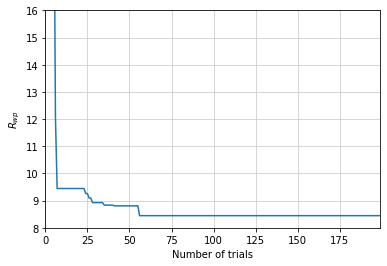

In [11]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([8, 16])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

GSAS-II binary directory: /opt/conda/GSASII/bindist


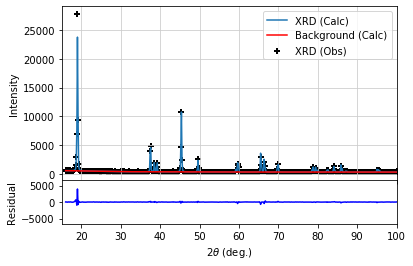

In [12]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        '%s/%s_seed%s_trial_%s.gpx' % (WORK_DIR, STUDY_NAME, RANDOM_SEED, study.best_trial.number))

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(15, 100)
    ax2.set_xlim(15, 100)
    plt.show()
    
rietveld_plot()